<div style="display: flex; justify-content: flex-end;">
    <div style="flex: 50%; padding: 10px;">
        <img src="Images/MSS_logo.svg" alt="Image 1 Alt Text" style="width: 80%">
    </div>
    <div style="flex: 50%; padding: 5px;">
        <img src="Images/SSF_logo.svg" alt="Image 2 Alt Text" style="width: 50%">
    </div>
</div>


# Rotation Algorithms Comparison


----
## Authors:

- Carlos Andrés del Valle:  <cdelv@unal.edu.co>
- Vasileios Angelidakis: <vasileios.angelidakis@fau.de>
- Sudeshna Roy: <sudeshna.roy@fau.de>
- José Daniel Muñoz: <jdmunozc@unal.edu.co>
- Thorsten Pöschel: <thorsten.poeschel@fau.de>
----

# Algorithm for the Integration of the Equation of Rotational Motion


## Abstract:

We introduce SPIRAL, a third-order integration algorithm for the rotational motion of extended bodies. It requires only one force calculation per time step, does not require quaternion normalization at each time step, and can be formulated for both leapfrog and synchronous integration schemes, making it compatible with many particle simulation codes. The stability and precision of SPIRAL exceed those of state-of-the-art algorithms currently used in popular DEM codes such as YADE, MercuryDPM, LIGGGHTS, PFC, and more, at only slightly higher computational cost. Also, beyond DEM, we see potential applications in all numerical simulations that involve the 3D rotation of extended bodies.

----

# Load Packages

In [1]:
using LinearAlgebra
using StaticArrays
using ReferenceFrameRotations
using DifferentialEquations
using Roots 
using Interpolations
using BenchmarkTools
using Statistics
using Plots, StatsPlots
using CSV, DataFrames
using Meshes
using MeshViz
using Printf

# Reference Frame Rotations:

Define some functions for going from the body frame to the lab frame and vice-versa. In other words, global and local frame. Also, some other helper functions. 

In [2]:
function norm2(v::Union{AbstractArray, Quaternion})
    return mapreduce(x -> x*x, +, v)
end
function norm1(v::Union{AbstractArray, Quaternion})
    return mapreduce(x -> abs(x), +, v)
end
function norm1(R::DCM)
     return max(norm1(R[:,1]), norm1(R[:,2]), norm1(R[:,3]))
end
function Lab_to_body(v::SVector{3, Float64}, q::Quaternion{Float64})::SVector{3, Float64}
    return vect(inv(q)*v*q)
end
function Lab_to_body(v::SVector{3, Float64}, R::DCM)::SVector{3, Float64}
    return R*v
end
function Body_to_lab(v::SVector{3, Float64}, q::Quaternion{Float64})::SVector{3, Float64}
    return vect(q*v*inv(q))
end
function Body_to_lab(v::SVector{3, Float64}, R::DCM)::SVector{3, Float64}
    return inv_rotation(R)*v
end
function Body_to_lab(v::SMatrix{3, 3, Float64, 9}, q::Quaternion{Float64})::SMatrix{3, 3, Float64, 9}
    R = quat_to_dcm(q) # Compute the DCM of the quaternion
    return inv_rotation(R)*v*R
end
function Body_to_lab(v::SMatrix{3, 3, Float64, 9}, R::DCM)::SMatrix{3, 3, Float64, 9}
    return inv_rotation(R)*v*R
end;

# Rigid Body Motion:

The motion of rigid bodies is ruled by the Euler equations of motion (equation 1). We will use some analytical solutions for a couple of cases to compare the accuracy of the different algorithms.

## Angular Velocity:

\begin{equation} \tag{1}
\begin{split}
\dot{\omega}_x &= \frac{M_x}{I_x}+ \omega_y\,\omega_z \frac{I_y - I_z}{I_x}\, , \\
\dot{\omega}_y &= \frac{M_y}{I_y}+ \omega_z\,\omega_x \frac{I_z - I_x}{I_y}\, , \\
\dot{\omega}_z &= \frac{M_z}{I_z}+ \omega_x\,\omega_y \frac{I_x - I_y}{I_z}\, ,
\end{split}
\end{equation}



In [3]:
function ω_dot(w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64})
    @inbounds SVector{3, Float64}(
            (M[1] + w[2]*w[3]*(II[2] - II[3]))/II[1],
            (M[2] + w[3]*w[1]*(II[3] - II[1]))/II[2],
            (M[3] + w[1]*w[2]*(II[1] - II[2]))/II[3]
        )
end;

----

## Quaternions:

Most algorithms use quaternions to describe the orientation of the particles. The time derivative of a quaternion is:

\begin{equation}\label{eq:quaternion_derivative} \tag{2}
     \dot{q} = \frac{1}{2} \tilde{\omega} q = \frac{1}{2} q \omega.
\end{equation}

Where $\tilde{\omega}$ is a quaternion with its real part equal to zero, and its vector part is the angular velocity in the lab frame. In the same way, $\omega$ is a quaternion in which the vector part is the angular velocity in the body frame. 

In [4]:
function q_dot(q::Quaternion, w::SVector{3}) # -> Calculate derivative with body frame angular velocity
    @inbounds ww = Quaternion(0.0, w[1], w[2], w[3])
    return 0.5*q*ww
end
function q_dot_lab(q::Quaternion, w::SVector{3}) # -> Calculate derivative with lab frame angular velocity
    @inbounds ww = Quaternion(0.0, w[1], w[2], w[3])
    return 0.5*ww*q
end;  

An alternative way of representing the rotation is through a DCM (Direct cosine matrix). The time derivative of a DCM is

\begin{equation}
    \dot{R} = \begin{pmatrix}
            0         & \omega_z  & -\omega_y \\
            -\omega_z & 0         & \omega_x \\
            \omega_y  & -\omega_x & 0 \\
            \end{pmatrix}R
\end{equation}

When the angular velocity is in the body frame. When the angular velocity is in the lab frame, it can be calculated as

\begin{equation}
    \dot{R} = \epsilon_{ijk}\omega_jR_{mk}
\end{equation}

Where $\epsilon_{ijk}$ is the Levi Civita symbol. 

In [5]:
# ddcm(R, w)  # -> Calculate derivative with body frame angular velocity
# Calculate derivative with lab frame angular velocity
function R_dot(w::SVector{3, Float64}, R::DCM{Float64})::SMatrix{3, 3, Float64, 9}
    output = MMatrix{3, 3, Float64, 9}(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    for i in 1:3
        @inbounds output[i, :] = cross(w, R[i, :])
    end
    return output
end;

We can verify the output of the previous code with 

In [6]:
#=
using TensorOperations

# Levi Civita
ϵ = zeros(3, 3, 3)
ϵ[1, 2, 3] = ϵ[2, 3, 1] = ϵ[3, 1, 2] = 1
ϵ[1, 3, 2] = ϵ[3, 2, 1] = ϵ[2, 1, 3] = -1

w = [1, 2, 3]
RR = rand(3,3)
res = zeros(3,3)

@tensor begin
    res[m, i] = ϵ[i, j, k] * w[j] * RR[m, k]
end

res - R_dot(SVector{3, Float64}(w), DCM(RR))
=#

----

### Inertia Tensor Values

- We need to satisfy the conditions of the analytic solution. $I_x \neq I_y$ and $I_y = I_z$.

To impose realistic inertia tensor values,  we consider a cylinder with constant density, mass $M$, radius $R$, and height $H$. The [inertia tensor of the cylinder](https://scienceworld.wolfram.com/physics/MomentofInertiaCylinder.html) in its principal axis frame is

\begin{equation}
    J = \begin{pmatrix}
            \frac{1}{2}MR^2 & 0 & 0 \\
            0               & \frac{1}{12}MH^2 + \frac{1}{4}MR^2 & 0 \\
            0               & 0 & \frac{1}{12}MH^2 + \frac{1}{4}MR^2
          \end{pmatrix}
\end{equation}

In this case, the cylinder is aligned with the x direction. 


These values, of course, can be changed to whatever, using a cylinder just to have something that makes sense. 

In [7]:
const ρ = 7750.0     # kg/m^3, steel density
const Rad = 5.0*1e-2   # 5 cm
const Hight = 15.0*1e-2  # 15 cm
const Mass = ρ*π*Rad*Rad*Hight  # M = Vρ

# Inertia tensor components in the principal axis frame
# Remember that Ix != Iy and Iy = Iz
const Ix = 0.5*Mass*Rad*Rad
const Iy = Iz = Mass*Hight*Hight/12 + 0.25*Mass*Rad*Rad

# The initial inertia tensor in the body frame
const InertiaP = SVector{3, Float64}(Ix, Iy, Iz)
const Inertia0 = SMatrix{3, 3, Float64, 9}(
    Ix, 0.0,  0.0, 
    0.0,  Iy, 0.0, 
    0.0,  0.0, Iz
);

println("Ix = ", Ix, " kg m^2")
println("Iy = Iz = ", Iy, " kg m^2")

Ix = 0.011412817061869173 kg m^2
Iy = Iz = 0.022825634123738343 kg m^2



----

## Analytic Solution: 

For the following two solutions, we assume that all the inertia tensor components are non-zero, $I_y = I_z$, and $I_x \neq I_z$. We also require that $\omega_x(t) \neq 0, \; \forall t$.

----

### Assuming $\tau_x \neq 0$:

For this case we require the torque to be $\vec{\tau} = (\tau_x, 0, 0)$ where $\tau_x$ is constant and non-zero. Be careful that the above assumptions are satisfied by the chosen initial conditions and torque. Under these assumptions, the solution of the angular velocity is:

\begin{equation}\label{eq:analytical_solution}
\begin{split}
\omega_x(t) & = \sqrt{x} = \omega_x(0) + \frac{M_x}{I_x}t, \\
\omega_y(x) & = K_1 \cos{(\eta x)} + K_2 \sin{(\eta x)}, \\
\omega_z(x) & = \omega_z(x) = E\eta \left[K_2 \cos{(\eta x)} - K_1 \sin{(\eta x)} \right],
\end{split}
\end{equation}
with the initial angular velocity $\vec{\omega}(0)$ and
\begin{equation}
\begin{split}
\eta &\equiv \frac{I_x}{2M_x}\sqrt{\frac{\left|(I_x-I_y)(I_z-I_x)\right|}{I_yI_z}},\\
E &\equiv \frac{2I_yM_x}{I_x(I_z - I_x)}, \\
K_{1} &\equiv \omega_y(0) \cos\left[\eta\, \omega_x(0)^{2}\right] - \frac{1}{E \eta}\omega_z(0) \sin\left[\eta\, \omega_x(0)^{2}\right],\\
K_{2} &\equiv \omega_y(0) \sin\left[\eta\, \omega_x(0)^{2}\right] + \frac{1}{E \eta}\omega_z(0) \cos\left[\eta\, \omega_x(0)^{2}\right]\,.
\end{split}
\end{equation}

-----

### Assuming $\tau_x = 0$:

For this case, we require the torque to be $\vec{\tau} = (0, 0, 0)$. Be careful that the above assumptions are satisfied by the chosen initial conditions and torque. Under these assumptions, the solution of the angular velocity is:

\begin{equation}
    \begin{split}
        & \omega_x(t) = \omega_x(0), \\
        & \omega_y(t) = K_1 \sin{(\eta\omega_x(0)t)} + K_2\cos{(\eta\omega_x(0)t)}, \\
        & \omega_z(t) = B\eta \left(K_1 \cos{(\eta\omega_x(0) t)} - K_2 \sin{(\eta\omega_x(0) t)} \right).
    \end{split}
\end{equation}

Where 

\begin{equation}
    \begin{split}
        & A = \frac{(I_x - I_y)(I_z - I_x)}{I_y\;I_z}, \\
        & \eta = \sqrt{|A|}, \\
        & B = \frac{I_y}{I_z - I_x}, \\
        & K_1 = \frac{\omega_z(0)}{B\eta}, \\
        & K_2 = \omega_y(0).
    \end{split}
\end{equation}


-----

The derivation of these analytical solutions is on our paper. 

-----


In [8]:
const A = (Ix - Iy)*(Iz - Ix)/(Iy*Iz)
const B = Iy/(Iz - Ix)
const sqrt_A = sqrt(-A)

function Sol_ω(t::Float64)::SVector{3, Float64}
    E = 2.0*τx*B/Ix
    ωx = ωx0 + τx*t/Ix
    if τx == 0.0
        η = sqrt_A
        C = B*η
        K1 = ωy0
        K2 = ωz0/C
        D = η*ωx0*t
    else
        η = 0.5*Ix*sqrt_A/τx
        C = E*η
        K1 = (C*ωy0*cos(η*ωx0^2) - ωz0*sin(η*ωx0^2))/C
        K2 = (C*ωy0*sin(η*ωx0^2) + ωz0*cos(η*ωx0^2))/C
        D = η*ωx^2
    end
    
    ωy = K1*cos(D) + K2*sin(D)
    ωz = C*(K2*cos(D) - K1*sin(D))
    return SVector{3, Float64}(ωx, ωy, ωz)
end;

----

# Problem Set Up

Set problem variables. Remember: they are global variables. Be careful!

In [9]:
# Initial orientation of the particle
const q0 = Quaternion(1.0, 0.0, 0.0, 0.0)

# Torque in the principal axis frame x direction, remember that only τx can be non 0. 
τx = 0.0             # N m
const τy = τz = 0.0  # N m

# Initial angular velocity, make sure that ωx0 and τx never make ωx(t) = 0. 
ωx0 =  0.3            # rad/s
ωy0 = -0.9            # rad/s
ωz0 =  0.6            # rad/s

# Torque and initial angular velocity in the principal axis frame
τ  = SVector{3, Float64}(τx, τy, τz)
ω0 = SVector{3, Float64}(ωx0, ωy0, ωz0);

----

# Error calculation:

To compute the error between the analytical solution and the solution from the different integration algorithms, we define the error metric:
\begin{equation}\label{eq:error_metric}
    ||\boldsymbol{v} - \boldsymbol{v}^\prime|| := \frac{\sum_i |v_i - v^\prime_i|}{\sum_i |v^\prime_i|}.
\end{equation}

Remember that the norm of a quaternion should be 1, then an error close to 0.1 is already way too big. 

In [10]:
R = quat_to_dcm(Quaternion(1,2,3,4))

function norm1(R::DCM)
     return max(norm1(R[:,1]), norm1(R[:,2]), norm1(R[:,3]))
end

norm1(R - R)

0

In [11]:
function q_error(q::Quaternion, t)
    return norm1(Quaternion(Rkt_sol_q(t)) - q) / norm1(Quaternion(Rkt_sol_q(t)))
end
function q_error(RR::DCM, t)
    Q = quat_to_dcm(Quaternion(Rkt_sol_q(t)))
    return norm1(RR - Q)/norm1(RR)
end
function w_error(w_body::SVector, t)
    return norm1(Sol_ω(t) - w_body)/norm1(Sol_ω(t))
end;

----

# ODE Solver: Benchmark Solution

We use Julia [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/) solver to solve equations 1 and 2 to ensure the accuracy of the solution. Equation 2 is solved with the analytical angular velocity. We use these solutions to calculate errors and compare.

In [12]:
# We are in the principal axis frame all the time
function Rkt_ω(du, u, p, t::Float64)
    @inbounds du[1] = (τx + (Iy - Iz)*u[2]*u[3])/Ix
    @inbounds du[2] = (τy + (Iz - Ix)*u[1]*u[3])/Iy
    @inbounds du[3] = (τz + (Ix - Iy)*u[1]*u[2])/Iz
    return nothing
end
# Solve the orientation using the analytic angular velocity
function Rkt_q(du, u, p, t::Float64)
    w = Sol_ω(t)
    @inbounds q = Quaternion(u[1], u[2], u[3], u[4])
    dq = q_dot(q, w)
    @inbounds du[1] = dq[1]
    @inbounds du[2] = dq[2]
    @inbounds du[3] = dq[3]
    @inbounds du[4] = dq[4]
    return nothing
end

function Benchmark_Solution(; tmax=10.0)
    tspan = (0.0, tmax)

    # Solve angular velocity
    u0 = [ωx0, ωy0, ωz0]
    prob_w = ODEProblem(Rkt_ω, u0, tspan)
    sol_w = solve(prob_w, alg_hints = [:auto, :interpolant], abstol=1e-14, reltol=1e-12) # We are quite picky with tolerance. We want good accuracy

    # Solve orientation
    u0 = [q0[1], q0[2], q0[3], q0[4]]
    prob_q = ODEProblem(Rkt_q, u0, tspan)
    sol_q = solve(prob_q, alg_hints = [:auto, :interpolant], abstol=1e-14, reltol=1e-12) # We are quite picky with tolerance. We want good accuracy
    return (sol_q, sol_w)
end

tmax = 25.0
Rkt_sol_q, Rkt_sol_w = Benchmark_Solution(tmax=tmax);

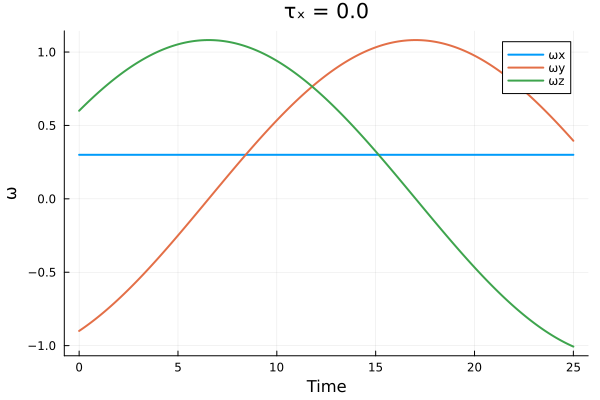

In [13]:
# Plot the solution, just to see it
plot(xlabel="Time", ylabel="ω", title="τₓ = "*string(τx))
plot!( 0.0:0.1:tmax, getindex.(Rkt_sol_w.(0.0:0.1:tmax), [1 2 3])[:,1], label="ωx", linewidth=2)
plot!(0.0:0.1:tmax, getindex.(Rkt_sol_w.(0.0:0.1:tmax), [1 2 3])[:,2], label="ωy", linewidth=2)
plot!(0.0:0.1:tmax, getindex.(Rkt_sol_w.(0.0:0.1:tmax), [1 2 3])[:,3], label="ωz", linewidth=2)

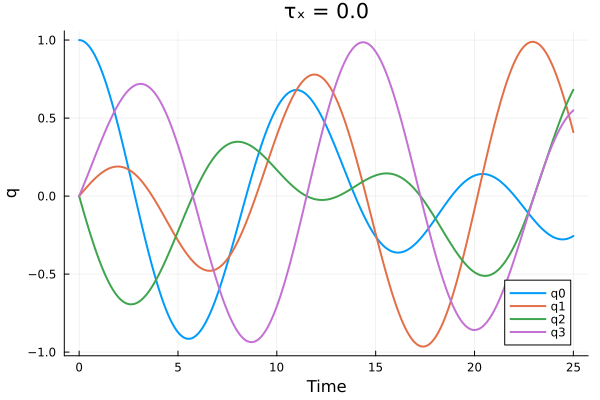

In [14]:
# Plot the solution, just to see it
plot(xlabel="Time", ylabel="q", title="τₓ = "*string(τx))
plot!( 0.0:0.1:tmax, getindex.(Rkt_sol_q.(0.0:0.1:tmax), [1 2 3 4])[:,1], label="q0", linewidth=2)
plot!(0.0:0.1:tmax, getindex.(Rkt_sol_q.(0.0:0.1:tmax), [1 2 3 4])[:,2], label="q1", linewidth=2)
plot!(0.0:0.1:tmax, getindex.(Rkt_sol_q.(0.0:0.1:tmax), [1 2 3 4])[:,3], label="q2", linewidth=2)
plot!(0.0:0.1:tmax, getindex.(Rkt_sol_q.(0.0:0.1:tmax), [1 2 3 4])[:,4], label="q3", linewidth=2)

In [15]:
function Rkt_Simulation(tmax::Float64, dt::Float64, n_samples::Int64)
    # Arrays to store results
    Error_q = zeros(n_samples)
    Time = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0
    
    for t in range(0.0, tmax, length=n_samples)
        Iter += 1
        @inbounds Time[Iter] = t
        w = Rkt_sol_w(t)
        q = Rkt_sol_q(t)
        @inbounds Prediction[Iter, :] = [q[1],q[2],q[3],q[4],w[1],w[2],w[3]] # We are in the body frame
        
        # Calculate the quaternion error
        # Error_q[Iter] = 0.0 # We use this solution to compare, then the error is always 0
        
        # Calculate the angular velocity error
        solution = Sol_ω(t)
        error = norm2(solution - w) # We are in the body frame
        @inbounds Error_w[Iter] = error
    end
    return (Time, Error_q, Error_w, Prediction)
end;

----

# Runge-Kutta 4:

[Runge-Kutta 4](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) is by far the most well-known ODE solver. It's also quite good. I like it a lot. However, we will see that is not nearly as good as a professional ODE solver like the one above. Runge-Kutta solves a first-order differential equation with 4 steps (hence the name).

If

\begin{equation}
    \dot{x} = f(x, t),
\end{equation}

then

\begin{equation}
    \begin{split}
        & x(t + dt) = x(t) + \frac{dt}{6}(k_1 + 2k_2 + 2k_3 +k_4), \\
        & k_1 = f\left(x(t), t \right), \\
        & k_2 = f\left(x(t) + dt\frac{k_1}{2}, t + \frac{dt}{2}\right),\\
        & k_3 = f\left(x(t) + dt\frac{k_2}{2}, t + \frac{dt}{2}\right),\\
        & k_4 = f\left(x(t) + dtk_3 , t + dt\right).\\
     \end{split}
\end{equation}

Here we can see why Runge-Kutta is not used for particle based simulation methods like MD and DEM... Evaluating $f$ means calculating forces. In this notebook, we have a given torque, then evaluating $f$ won't have any cost, but in real life, it will be very costly. Also, if you are willing to do 4 force calculations per step there are better methods available. For example, [PEFRL](https://arxiv.org/abs/cond-mat/0110585) (for translational motion). Runge-Kutta is not known for being the most stable method after all... It's also quite slow. 

In [16]:
function Rkt4_f(x::SVector{7, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64})::SVector{7, Float64}
    @inbounds q = Quaternion(x[1], x[2], x[3], x[4])
    @inbounds w = SVector{3, Float64}(x[5], x[6], x[7])
    
    # Compute derivatives
    Q_dot = q_dot(q, w)
    w_dot = ω_dot(w, M, II)
    
    return @inbounds SVector{7, Float64}(Q_dot[1], Q_dot[2], Q_dot[3], Q_dot[4], w_dot[1], w_dot[2], w_dot[3])
end

"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Rkt4_step(q::Quaternion, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=true)
    M = τ # In this case, we already have the torque in the principal frame (and its constant)
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Runge-Kutta 7D vector
    @inbounds X = SVector{7, Float64}(q[1], q[2], q[3], q[4], w[1], w[2], w[3])
    
    k1 = Rkt4_f(X            , M, II) # We would need to update the torque on each call if it werent constant
    k2 = Rkt4_f(X + 0.5*dt*k1, M, II)
    k3 = Rkt4_f(X + 0.5*dt*k2, M, II)
    k4 = Rkt4_f(X + dt*k3    , M, II)
    X += dt*(k1 + 2.0*k2 + 2.0*k3 + k4)/6
    
    @inbounds q = Quaternion(X[1], X[2], X[3], X[4])
    if normalize q /= norm(q); end   # normalize the quaternion
    
    @inbounds w = SVector{3, Float64}(X[5], X[6], X[7])
    
    # Go back to the global reference frame
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity
end

function Rkt4_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0  # Initial time
    q = q0 # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})

    for i in 1:n_steps
        # One step
        q, w_body, w = Rkt4_step(q, w, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----
To prevent any confusion regarding the reference frames used in the algorithms, we establish the following notation. Quantities described in the principal axis reference frame are represented like this: $\boldsymbol{\omega}$. Variables in the lab frame are distinguished by a superscript: $\boldsymbol{\omega}^{lab}$. 

Furthermore, in the principal axis frame, the inertia tensor is represented as $\boldsymbol{I}$ and is treated mathematically as a vector because it is a diagonal matrix. In the lab frame, the inertia tensor is denoted as $\boldsymbol{J}$ and is a 3x3 symmetrical matrix. The quaternion that represents the orientation is the same for both reference frames.

Note that the angular velocity derivative is formulated in the principal axis reference frame. This derivative is a function of the inertia tensor, the angular velocity, and the torque. Similarly, the quaternion derivative is also formulated in the principal axis frame. To calculate the derivative in the lab frame, you can use the equation $\dot{q} = \frac{1}{2}q\omega$. It's important to recognize that this equation, along with the other one require the angular velocity to be converted into an imaginary quaternion. Alternatively, the quaternion derivative can be expressed using matrix-vector multiplication. Consequently, you can represent $\dot{q}$ as a function of the quaternion and the angular velocity vector. For clarity, in the algorithm description, we show how to evaluate each derivative with brackets. For example, $\dot{\boldsymbol{\omega}}\left[\boldsymbol{\omega}, \boldsymbol{M}\right]$.

---

# Direct Euler:

This algorithm is used by:

- Mfix: In their [docs](https://mfix.netl.doe.gov/doc/mfix-archive/mfix_current_documentation/dem_doc_2012-1.pdf) they show that they have 2 algorithms, Direct Euler and 2th order Adams Bashforth. Euler is the default.

- BlazeDEMGPU: In this [paper](https://www.sciencedirect.com/science/article/pii/S235271101630005X) they say near eq 7 that they use Direct Euler. 

- EDEM: [here](https://2022.help.altair.com/2022.2/EDEM/Simulator.htm) says they use Euler and both Position and Velocity Verlet. Also [here](https://altair.com/docs/default-source/resource-library/ebook_what_is_dem_theoretical_background_behind_the_discrete_element_method.pdf?sfvrsn=975cfcf1_3) page 9. Euler is the default. 


The second-order Direct Euler algorithm, updates the angular velocities and the quaternions through

\begin{equation}
\begin{split}
\boldsymbol{\omega}(t + \Delta t) &= \boldsymbol{\omega}(t) + \Delta t\,\dot{\boldsymbol{\omega}}\left[\boldsymbol{\omega}(t),\boldsymbol{M}(t)\right] \\
q(t + \Delta t) &= q(t) + \Delta t\,\dot{q}\left[q(t), \boldsymbol{\omega}(t + \Delta t)\right]\,.           
\end{split}
\end{equation}


This algorithm requires normalization of the quaternions in each time step. All quantities are in the principal axis frame.

----

<font color='red'>
Warning: In the algorithm derivation, it is implicit that the second derivative should not depend on the first one (the angular velocity derivative depends on angular velocity). But, in many cases, one can get away with it. The same happens in the LeapFrog and Direct Euler algorithms. This is because they come from the Taylor series expansion of f(x, t). 
</font>

In [17]:
"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Direct_Euler_step(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=true)
    # Move torque to principal axis frame
    M = τ # In this case, we already have the torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Update angular velocity in the principal axis frame
    w +=  ω_dot(w, M, II)*dt
    
    # Update orientation
    q += q_dot(q, w)*dt
    if normalize q/= norm(q); end   # normalize the quaternion
    
    # Go back to the global reference frame
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity
end

function Direct_Euler_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0  # Initial time
    q = q0 # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})

    for i in 1:n_steps
        # One step
        q, w_body, w = Direct_Euler_step(q, w, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# Velocity Verlet Algorithm:

This algorithm is used by:

- EDEM: [here](https://2022.help.altair.com/2022.2/EDEM/Simulator.htm) says they use Euler and Position and Velocity Verlet. Also [here](https://altair.com/docs/default-source/resource-library/ebook_what_is_dem_theoretical_background_behind_the_discrete_element_method.pdf?sfvrsn=975cfcf1_3) page 9. Euler is the default.  

- LIGGGHTS: In the docs, they say that they use Verlet [here](https://www.cfdem.com/media/DEM/docu/run_style.html).

- GranOO: In the docs, they say that they use Verlet [here](https://www.granoo.org/doc.html#plugin-velocity-verlet-step1). Also in the [paper](https://www.sciencedirect.com/science/article/abs/pii/S0965997814000672?via%3Dihub).

The second-order Velocity Verlet algorithm, updates the angular velocities and the quaternions through

\begin{equation}
\begin{split}
\boldsymbol{\omega}\left(t + \frac{\Delta t}{2}\right) &= \boldsymbol{\omega}(t) + \frac{\Delta t}{2}\,\dot{\boldsymbol{\omega}}\left[\boldsymbol{\omega}(t),\boldsymbol{M}(t)\right] \\
q(t + \Delta t) &= q(t) + \Delta t\, \dot{q}\left[q(t), \boldsymbol{\omega}(t + \Delta t)\right]\,.
\end{split}
\end{equation}
Compute the torques, $\boldsymbol{M}(t + \Delta t)$, and then
\begin{equation}
 \boldsymbol{\omega}(t + \Delta t) = \boldsymbol{\omega}\left(t + \frac{\Delta t}{2}\right) + \frac{\Delta t}{2}\dot{\boldsymbol{\omega}}\left[\boldsymbol{\omega}\left(t + \frac{\Delta t}{2}\right),\boldsymbol{M}(t + \Delta t)\right]\,.
 \end{equation}
 
This algorithm requires normalization of the quaternions in each time step. All quantities are in the principal axis frame.

----

<font color='red'>
Warning: In the algorithm derivation, it is implicit that the second derivative should not depend on the first one (the angular velocity derivative depends on angular velocity). But, in many cases, one can get away with it. The same happens in the LeapFrog and Direct Euler algorithms. This is because they come from the Taylor series expansion of f(x, t). 
</font>

In [18]:
"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Verlet_step(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=true)
    # Move torque to principal axis frame
    M = τ # In this case, we already have the torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Update angular velocity in the principal axis frame
    w +=  ω_dot(w, M, II)*dt*0.5
    
    # Update orientation
    q += q_dot(q, w)*dt
    if normalize q /= norm(q); end   # normalize the quaternion
    
    # Recalculate Forces
    M = τ # In this case, we already have the torque in the principal frame
    
    # Update angular velocity in the principal axis frame
    w +=  ω_dot(w, M, II)*dt*0.5
    
    # Go back to the global reference frame
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity
end

function Verlet_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0  # Initial time
    q = q0   # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})

    for i in 1:n_steps
        # One step
        q, w_body, w = Verlet_step(q, w, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

---

# Augmented Second Order Buss Algorithm:

This algorithm is used by:

- PFC: The implementation here follows from PFC [docs](https://docs.itascacg.com/pfc600/pfc/docproject/source/manual/numerical_simulations_with_pfc/pfc_formulation/law_of_motion.html?highlight=integration).


The original paper: [Accurate and Efficient Simulation of Rigid-Body Rotations](https://www.sciencedirect.com/science/article/abs/pii/S0021999100966026).


Unlike the above-described algorithms, the second-order Buss algorithm updates the inertia tensor and uses the quantities in the lab frame. Prior to the update, we compute

\begin{equation}
\begin{split}
\boldsymbol{J}(t) &= \hat{A}^{-1}(t)\, \boldsymbol{I}\\
\boldsymbol{\omega}^{lab}(t) &= J^{-1}(t)\,\boldsymbol{L}^{lab}(t)\\
\dot{\boldsymbol{\omega}}^{lab}(t) &= J^{-1}(t)\left[\boldsymbol{M}^{lab}(t) - \boldsymbol{\omega}^{lab}(t) \times \boldsymbol{L}^{lab}(t)\right]\,.
\end{split}
\end{equation}

$/hat{A}$ is the rotation matrix for transforming lab-fixed coordinates into body-fixed coordinates and $/vec{J}$ is the inertia tensor calculated from the inertia tensor in the principal axis frame $\vec{I}$. The rotation matrix can be calculated using the quaternion. Then, the update proceeds in two steps. First, compute

\begin{equation}
\begin{split}
\bar{\boldsymbol{\omega}} &= \boldsymbol{\omega}^{lab}(t) + \frac{\Delta t}{2}\,\dot{\boldsymbol{\omega}}^{lab}(t) + \frac{\Delta t^2}{12}\left[\dot{\boldsymbol{\omega}}^{lab}(t)\times \boldsymbol{\omega}^{lab}(t)\right] \\
\theta &= \left|\bar{\boldsymbol{\omega}}\right|\,\Delta t
\end{split}
\end{equation}

and then

\begin{equation}
\begin{split}
q(t + \Delta t) &= \left[\cos{\frac{\theta}{2}} + \frac{\boldsymbol{\bar{\omega}}}{|\boldsymbol{\bar{\omega}}|}\sin{\frac{\theta}{2}}\right]\,q(t) \\[3mm]
\boldsymbol{L}^{lab}(t + \Delta t) &= \boldsymbol{L}^{lab}(t) + \Delta t\,\boldsymbol{M}^{lab}(t)\,,
\end{split}
\end{equation}

The version of the Buss algorithm presented here is the same as the one in PFC7 documentation. However, note that Buss' original version uses rotation matrices instead of quaternions. 

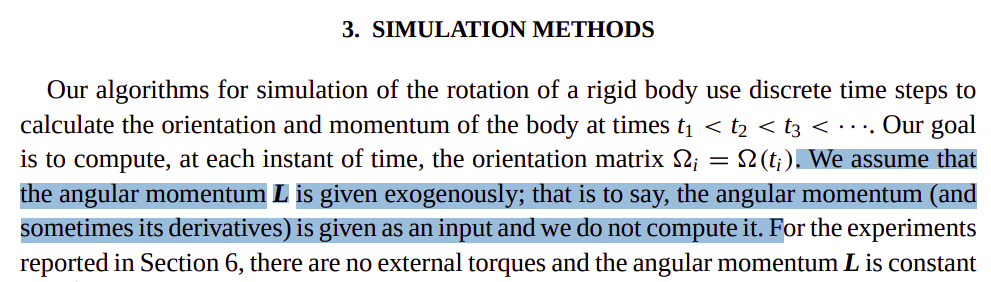

In [19]:
"""
- q: Current particle orientation.
- L: Current angular momentum (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- J: Inertia tensor in the principal axis frame. As a 3x3 diagonal matrix. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Buss_Step(q::Quaternion{Float64}, L::SVector{3, Float64}, M::SVector{3, Float64}, J::SMatrix{3, 3, Float64, 9}, dt::Float64; normalize::Bool=false)
    # Compute inverse inertia tensor
    Inv_Inertia::SMatrix{3, 3, Float64, 9} = Body_to_lab(inv(J),q)
    
    # Compute current angular velocity w(t) = I^-1(t) L(t)
    w::SVector{3, Float64} = Inv_Inertia*L
    
    # Compute torque
    M = Body_to_lab(τ,q) # In this case we need the torque in the lab frame
    
    # Compute w_dot(t)
    w_dot::SVector{3, Float64} = Inv_Inertia*(M - cross(w,L))
    
    # Omega average
    w_bar::SVector{3, Float64} = w + 0.5*dt*w_dot + (dt/4.0)^2*cross(w_dot, w)
    
    # New orientation, rotation arround axis w_bar of angle θ
    θ::Float64 = norm(w_bar)*dt
    q = cos(θ/2)*q + sin(θ/2)*w_bar*q/norm(w_bar) # q(t + dt)
    if normalize q /= norm(q); end   # normalize the quaternion

    # Compute inverse inertia tensor
    Inv_Inertia = Body_to_lab(inv(J),q)
    
    # Update angular momentum. PFC docs and Buss paper don't say how to do it... I assumed this.
    L += dt*M
    
    # Compute new angular velocity w(t+dt) = I^-1(t+dt) L(t+dt)
    w = Inv_Inertia*L
    
    return (q, Lab_to_body(w,q), L) # We need the body frame velocity
end

function Buss_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=false)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0          # Initial time
    q = q0           # Initial Orientation
    L = InertiaP.*Body_to_lab(ω0, q) # Initial Angular momentum
    
    for i in 1:n_steps
        # One step
        q, w_body, L = Buss_Step(q, L, τ, Inertia0, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# 4th Order Johnson Algorithm

This algorithm is used by:

- PFC: PFC [docs](https://docs.itascacg.com/pfc600/pfc/docproject/source/manual/numerical_simulations_with_pfc/pfc_formulation/law_of_motion.html?highlight=integration) for some reason don't clearly state that they use Johnson algorithm. Then, it's easy to think that they use Buss 4th order algorithm. However, in [here](https://docs.itascacg.com/pfc600/pfc/pfcmodule/doc/manual/clump_manual/clump_commands/cmd_clump_order.html#command:clump.order), they directly state that they use Johnson. 


The original paper: [Quaternion-based rigid body rotation integration algorithms for use in particle methods](https://onlinelibrary.wiley.com/doi/abs/10.1002/nme.2210).


Johnson's algorithm is based on a Runge-Kutta-4 scheme for the update of the quaternion:

\begin{equation}
  q(t + \Delta t) = q(t) + \frac{\Delta t}{6}\left(k_1 + 2k_2 + 2k_3 +k_4\right)\,,
\end{equation}

with

\begin{equation}
\begin{split}
k_1 &= \dot{q}\left[q(t),\; \boldsymbol \omega(t)\right]\\
k_2 &= \dot{q}\left[q(t) + \Delta t\,\frac{k_1}{2},\; \boldsymbol{\omega}(t)\right] \\
k_3 &= \dot{q}\left[q(t) + \Delta t\,\frac{k_2}{2},\; \boldsymbol{\omega}(t)\right] \\
k_4 &= \dot{q}\left[q(t) + \Delta t\,k_3,\; \boldsymbol{\omega}(t)\right]\,.
\end{split}
\end{equation}

Then, update the angular momentum

\begin{equation}
    \boldsymbol L^{lab}(t + \Delta t) = \boldsymbol L^{lab}(t) + \Delta t  \boldsymbol M^{lab}(t)\,.
\end{equation}

Note that Johnson suggests using a second-order predictor-corrector algorithm for evolving angular momentum. This would require 2 force calculations and updating the quaternion two times. However, for the tests, the algorithm wouldn't have benefited from the predictor-corrector scheme because the torque is given and constant. This algorithm requires the quaternion to be normalized. 

In [20]:
function Johnson_Rkt4_f(q::Quaternion{Float64}, L::SVector{3, Float64}, M::SVector{3, Float64}, Inv_J::SMatrix{3, 3, Float64, 9}, dt::Float64)   
    LL::SVector{3, Float64} = L # + M*dt # In Johnson paper they add dt*M, in PFC docs they dont. 
    w::SVector{3, Float64} = Body_to_lab(Inv_J, q)*LL  # Angular velocity in the lab frame, PFC and the paper do it this way....
    
    # Compute derivatives, this way theres no need to move angular velocity to body frame
    return q_dot_lab(q, w)
end

"""
- q: Current particle orientation.
- L: Current angular momentum (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- J: Inertia tensor in the principal axis frame. As a 3x3 diagonal matrix. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Johnson_Step(q::Quaternion{Float64}, L::SVector{3, Float64}, M::SVector{3, Float64}, J::SMatrix{3, 3, Float64, 9}, dt::Float64; normalize::Bool=true)
    # Compute inverse inertia tensor in the principal axis frame
    Inv_J::SMatrix{3, 3, Float64, 9} = inv(J)   # J^-1
    
    # Compute torque, in this case we need it in the lab frame
    M = Body_to_lab(τ, q)
    
    # Runge-Kutta-4 like quaternion update
    k1::Quaternion{Float64} = Johnson_Rkt4_f(q            , L, M, Inv_J, dt)
    k2::Quaternion{Float64} = Johnson_Rkt4_f(q + 0.5*dt*k1, L, M, Inv_J, dt)
    k3::Quaternion{Float64} = Johnson_Rkt4_f(q + 0.5*dt*k2, L, M, Inv_J, dt)
    k4::Quaternion{Float64} = Johnson_Rkt4_f(q + dt*k3    , L, M, Inv_J, dt)
    q += dt*(k1 + 2.0*k2 + 2.0*k3 + k4)/6.0
    if normalize q/=norm(q); end
    
    # Compute torque, in this case we need it in the lab frame
    M = Body_to_lab(τ, q)
    
    # Update angular momentum in lab frame
    L += dt*M
    
    # Angular velocity in the body frame 
    w::SVector{3, Float64} = Inv_J*Lab_to_body(L, q)
    
    return (q, w, L) # We need the body frame velocity
end

function Johnson_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0          # Initial time
    q = q0           # Initial Orientation
    L = Inertia0*Body_to_lab(ω0, q) # Initial Angular momentum
    
    for i in 1:n_steps
        # One step
        q, w_body, L = Johnson_Step(q, L, τ, Inertia0, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# Fincham Leapfrog:

This algorithm is used by:

- YADE: YADE [docs](https://www.yade-dem.org/doc/formulation.html#orientation-aspherical).
- Esys_Particle: [Paper](https://www.researchgate.net/publication/44003760_The_ESyS_Particle_A_New_3-D_Discrete_Element_Model_with_Single_Particle_Rotation) (page 11).

- WooDEM: wooDem [docs](https://woodem.org/theory/leapfrog.html#orientation) are exaclty the same as YADE docs.


The original paper: [Leapfrog Rotational Algorithms](https://www.tandfonline.com/doi/abs/10.1080/08927029208022474).

The second-order Fincham Leapfrog algorithm uses angular momenta instead of angular velocities. It includes a mid-step interpolation of the quaternion to increase the stability. The update from $t$ to $t+\Delta t$ is performed in two steps. First, the angular momenta are updated as in Leapfrog schemes:

\begin{equation}
\boldsymbol{L}^{lab}\left(t + \frac{\Delta t}{2}\right) = \boldsymbol{L}^{lab}\left(t - \frac{\Delta t}{2}\right) + \Delta t\, \boldsymbol{M}^{lab}(t)\,.
\end{equation}

In this algorithm, the torque and angular momentum are in the lab reference frame. Then, we update the quaternion with a predictor-corrector scheme. Here, we need the derivative of the quaternion at different angular velocities:

\begin{equation}
\begin{split}
&q_a = q + \frac{\Delta t}{2}\,\dot{q}\left[q(t), \boldsymbol{\omega}(t)\right] \\
&q(t + \Delta t) = q + \Delta t\,\dot{q}\left[q_a, \boldsymbol{\omega}(t)\right].
    \end{split}
\end{equation}

The angular velocities in the rotating body-fixed frame can be calculated by 

\begin{equation}
\begin{split}
&\boldsymbol \omega(t) =\hat{A}\left[\boldsymbol{L}\left(t - \frac{\Delta t}{2}\right) + \frac{\Delta t}{2}\,\boldsymbol{ M}(t)\right]\\
&\boldsymbol \omega\left(t + \frac{\Delta t}{2}\right) = \hat{A}\, \boldsymbol{L}\left(t + \frac{\Delta t}{2}\right)\,,
\end{split}
\end{equation}

where $\hat{A}$ is the rotation matrix to translate the coordinates from lab-fixed coordinates to body-fixed coordinates. The matrix can be calculated using the quaternion. This algorithm requires normalization of the quaternion.

In [21]:
"""
- q: Current particle orientation.
- L: Current angular momentum (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Fincham_Step(q::Quaternion{Float64}, L::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=true)    
    # Compute torque
    M = Body_to_lab(τ, q) # In this case we need the torque in the lab frame
    
    # Update angular momentum
    L_half::SVector{3, Float64} = L + 0.5*dt*M 
    L += dt*M
    
    # Angular velocity in the body frame
    w_half::SVector{3, Float64} = Lab_to_body(L_half, q)./II
    w::SVector{3, Float64} = Lab_to_body(L, q)./II
    
    # Calculate mid step quaternion
    q_half::Quaternion{Float64} = q + 0.5*dt*q_dot(q, w_half)  # q(t + dt/2)
    if normalize q_half /= norm(q_half); end
    
    # Update orientation
    q += dt*q_dot(q_half, w)
    if normalize q /= norm(q); end   # normalize the quaternion
    
    return (q, w, L) # We need the body frame velocity
end

function Fincham_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0          # Initial time
    q = q0           # Initial Orientation
    L = InertiaP.*Body_to_lab(ω0, q) # Initial Angular momentum
    
    # Initialize leapfrog
    L -= 0.5*dt*Body_to_lab(τ,q) # L(t - dt/2)
    
    for i in 1:n_steps
        # One step
        q, w_body, L = Fincham_Step(q, L, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T - 0.5*dt) # Leapfrog velocity is ofset by dt/2
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# Omelyan Algorithm: 

This algorithm is used by:

- YADE: [docs](https://www.yade-dem.org/doc/formulation.html#orientation-aspherical).

The original paper: [Algorithm for numerical integration of the rigid-body equations of motion](https://arxiv.org/abs/physics/9901027).

Omelyan's third-order Advance Leapfrog algorithm proceeds as follows:

\begin{equation}
\label{eq:Omelyan98_algorithm}
\begin{split}
\boldsymbol{\omega}\left(t+\frac{\Delta t}{2}\right) &= \boldsymbol{\omega}\left(t-\frac{\Delta t}{2}\right) + \Delta t\,\dot{\boldsymbol{\omega}}\left[\boldsymbol{\omega}(t),\boldsymbol{M}(t)\right] \\
q(t+\Delta t) &= \frac{\left(1-\frac{\Delta t^2}{16}\left| \boldsymbol{\omega}\left(t+\frac{\Delta t}{2}\right)\right|^2\right)\mathbb{1} + \Delta t\, \dot{q}\left[q(t), \boldsymbol{\omega}(t + \frac{\Delta t}{2})\right]}{1 + \frac{\Delta t^2}{16} \left|\boldsymbol{\omega}\left(t+\frac{\Delta t}{2}\right)\right|^2}\,q(t)\, ,
\end{split}
\end{equation}

where $\mathbb{1}$ is the identity quaternion. However, the derivative of the angular velocity at time $t$ requires 
the angular velocity at time $t$, which is yet unknown. To solve this problem, Omelyan proposed the approximation

\begin{equation}
\label{eq:Omelyan_aprox}
\omega_\alpha(t)\,\omega_\beta(t) \approx \frac{1}{2}\left[\omega_\alpha\left(t-\frac{\Delta t}{2}\right)\omega_\beta\left(t-\frac{\Delta t}{2}\right) + \omega_\alpha\left(t+\frac{\Delta t}{2}\right)\omega_\beta\left(t+\frac{\Delta t}{2}\right)\right].
\end{equation}

This approximation turns the algorithm into a system of nonlinear equations that can be efficiently solved by iteration, with the initial guess
\begin{equation}
    \boldsymbol{\omega}^{(0)}(t) = \boldsymbol{\omega}\left(t-\frac{\Delta t}{2}\right)\,.
\end{equation}

Experience shows that for a sufficiently small time step about three iterations are enough to achieve convergence. For comparisons in this paper, we always used three iterations.

By construction, this algorithm preserves the norm of the quaternions. Therefore, no renormalization would be required. However, we found that the algorithm accumulates significant numerical error over time and can become unstable. We suggest sporadically normalizing the quaternion when using this algorithm. 

In [22]:
function Omelyan_98_move_w(w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; niter::Int64=3)::SVector{3, Float64}
    ww::SVector{3, Float64} = w
    # Solve non-linear system
    for i in 1:niter
        @inbounds ww = w + dt*SVector{3, Float64}(
            (M[1] + 0.5*(w[2]*w[3]+ww[2]*ww[3])*(II[2]-II[3]))/II[1],
            (M[2] + 0.5*(w[3]*w[1]+ww[3]*ww[1])*(II[3]-II[1]))/II[2],
            (M[3] + 0.5*(w[1]*w[2]+ww[1]*ww[2])*(II[1]-II[2]))/II[3])
    end
    return ww
end
"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- niter: Number of iterations for solving the nonlinear system. 
- normalize: Whether or not to normalize the quaternion.
"""
function Omelyan_Step(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; niter::Int64=3, normalize::Bool=false)
    # Move torque to principal axis frame
    M = τ # In this case, we already have a torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Update velocity 
    w = Omelyan_98_move_w(w, M, II, dt, niter=niter) # w(d + dt/2)
    
    # Update quaternion
    a::Float64 = norm2(w)*(dt/4.0)^2
    a1::Float64 = 1.0 - a
    a2::Float64 = 1.0 + a
    q = (a1*q + q_dot(q, w)*dt)/a2
    if normalize q /= norm(q); end   # normalize the quaternion
    
    # Go back to lab frame    
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity
end

function Omelyan_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; niter::Int64=3, normalize::Bool=false)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0 # Initial time
    q = q0  # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})
    
    # Initialize leapfrog
    w -= 0.5*dt*ω_dot(Lab_to_body(w, q), τ, InertiaP) # w(t - dt/2)

    for i in 1:n_steps
        # One step
        q, w_body, w = Omelyan_Step(q, w, τ, InertiaP, dt, niter=niter, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T - 0.5*dt) # Leapfrog velocity is ofset by dt/2
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# MercuryDPM algorithm

The algorithm used by MercuryDPM for non-spherical particles is described in PFC4 manual and in [this paper]{https://arxiv.org/abs/2310.05027} and uses rotation matrices to represent the particle orientation. We are not aware of the algorithm's name or original reference. The current version of PFC uses the Buss algorithm or the Johnson algorithm. In this algorithm, all the quantities are in the lab reference frame. The algorithm proceeds as follows:

First, the angular velocity and momentum are updated iteratively,

\begin{equation}
\begin{split}
\boldsymbol{L}_n^{lab} &= \boldsymbol{J}\,\boldsymbol{\omega}_n^{lab} \\
\boldsymbol{\omega}_{n+1}^{lab} &= \boldsymbol{\omega}_0^{lab} + \Delta t\,\boldsymbol{J}^{-1}\left(\boldsymbol{M}^{lab} - \boldsymbol{\omega}_{n}^{lab}\times \boldsymbol{L}_{n}^{lab}\right)\,.
\end{split}
\end{equation}

Then, the orientation is updated, 
\begin{equation}
    \hat{A}(t + \Delta t) = \hat{A}(t) + \Delta t\,\dot{\hat{A}}(t)\,,
\end{equation}

where $\hat{A}$ is the rotation matrix representing the particle's orientation. Its derivative reads

\begin{equation}
    \dot{\hat{A}} = \varepsilon_{ijk}\,\omega_j^{lab}\, \hat{A}_{mk}\,,
\end{equation}

where $\varepsilon_{ijk}$ is the Levi-Civita symbol. Einstein's summation notation applies. In this paper, we used three iterations, as in MercuryDPM.

In [23]:
function Mercury_move_w(w::SVector{3, Float64}, M::SVector{3, Float64}, I::SMatrix{3, 3, Float64, 9}, Inv_I::SMatrix{3, 3, Float64, 9}, dt::Float64; niter::Int64=3)::SVector{3, Float64}
    w_n::SVector{3, Float64} = w
    
    # Update angular velocity in the principal axis frame
    for i in 1:niter
        L_n::SVector{3, Float64} = I*w_n
        w_n = w + dt*Inv_I*(M - cross(w_n, L_n)) # w0 + dt*w_dot
    end
    return w_n
end

"""
- q: Current particle orientation.
- L: Current angular momentum (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- J: Inertia tensor in the principal axis frame. As a 3x3 diagonal matrix. 
- dt: Time step.
- niter: Number of iterations for solving the nonlinear system. 
- normalize: Whether or not to normalize the quaternion.
"""
function Mercury_step(RR::DCM{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, J::SMatrix{3, 3, Float64, 9}, dt::Float64; niter::Int64=3, normalize::Bool=true)    
    # Calculate Lab frame Inertia tensor
    I::SMatrix{3, 3, Float64, 9} = Body_to_lab(J, RR)
    Inv_I::SMatrix{3, 3, Float64, 9} = inv(I)
    
    # Move torque to lab frame
    M = Body_to_lab(τ, RR)
    
    # Update angular velocity
    w = Mercury_move_w(w, M, I, Inv_I, dt, niter=niter) # w(t + dt/2)
    
    # Update orientation
    RR += dt*R_dot(w, RR)
    if normalize RR = orthonormalize(RR); end
    
    return (RR, Lab_to_body(w, RR), w) # We need the body frame velocity
end

function Mercury_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; niter::Int64=3, normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0  # Initial time
    q = q0 # Initial Orientation
    RR = quat_to_dcm(q)
    
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})
    
    # Initialize leapfrog
    w -= 0.5*dt*ω_dot(Lab_to_body(w, q), τ, InertiaP) # w(t - dt/2)
    
    for i in 1:n_steps
        # One step
        RR, w_body, w = Mercury_step(RR, w, τ, Inertia0, dt, niter=niter, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(RR, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T - 0.5*dt) # Leapfrog velocity is ofset by dt/2
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# SPIRAL Leapfrog Algorithm


The third-order \textsc{SPIRAL} (stable particle rotation integration algorithm) algorithm applies to leapfrog and non-leapfrog architectures. Here, we describe the leapfrog version. The non-leapfrog version is presented in bellow. We describe the 3D orientation of a rigid body at time $t$ by unit quaternions $q(t)$. To derive an expression for $q(t + \Delta t)$, we start with the quaternion's time derivative,

\begin{equation}\label{eq:Dotq}
    \dot{q} = \frac{dq}{dt} = \frac{1}{2}\omega(t) q\,,
\end{equation}

where $\omega=\{0,\omega_x,\omega_y,\omega_z\}$ is a pure imaginary quaternion representing the angular velocity $\vec\omega=\{\omega_x,\omega_y,\omega_z\}$ in the reference frame of the 
rotating body. We assume that $\omega$ depends only explicitly on time and solve the differential equation by separation of variables

\begin{equation}
    \int_t^{t + \Delta t} \frac{\text{d}q}{q} = \frac{1}{2}\int_{t}^{t + \Delta t} \omega(t^\prime) \text{d}t^\prime\,,
\end{equation}

to obtain 

\begin{equation}
\label{eq:TPq}
    q(t + \Delta t) = q(t)\,\exp\left(\frac{1}{2}\int_{t}^{t + \Delta t} \omega(t^\prime)\, \text{d}t^\prime\right) \,.
\end{equation}

We expand the unknown $\omega(t^\prime)$ in a Taylor series around $a$,

\begin{equation}\label{eq:TaylorOmega}
    \omega(t^\prime) = \omega(a) + \dot{\omega}(a)(t^\prime - a) +  \frac{1}{2}\ddot{\omega}(a)(t^\prime - a)^2 + \mathcal{O}\left[\left(t^\prime - a\right)^3\right]\,,
\end{equation}

take $a=t + \frac{\Delta t}{2}$ (leapfrog assumption), and insert it:

\begin{equation}
        q(t + \Delta t) = q(t)\,\exp\left[\frac{\Delta t}{2}\omega\left(t + \frac{\Delta t}{2}\right) + \mathcal{O}(\Delta t^3)\right]\,.
        \label{eq:leap}
%        \mbox{, with }
%        O(dt^3)\approx \frac{dt^3}{48}\ddot{\omega}\left(t + \frac{dt}{2}\right) \quad .
\end{equation}

The exponential of a purely imaginary quaternion $\theta \hat{u}$, where $\theta$ is a scalar and $\hat{u}=\{0,u_x,u_y,u_z\}$, a unit quaternion, reads

\begin{equation}\label{eq:QuaternionPureRotation}
    e^{\theta\hat{u}} = \cos{\theta} + \boldsymbol{u}\sin{\theta}\,,
\end{equation}

with the unit vector $\boldsymbol u=\{u_x,u_y,u_z\}$. Then 

\begin{equation}
\label{eq:TPqfinal}
    q(t+\Delta t) = q(t)\left(\cos{\theta_1} + \frac{\boldsymbol{\omega}\left(t + \frac{\Delta t}{2}\right)}{\left|\boldsymbol{\omega}\left(t + \frac{\Delta t}{2}\right)\right|}\sin{\theta_1} \right),\quad \text{with} \quad
    \theta_1 \equiv \frac{\Delta t}{2}\left|\boldsymbol{\omega}\left(t + \frac{\Delta t}{2}\right)\right|\,.
\end{equation}

The shown transformations preserve the norm of the initial quaternion, thus eliminating the need for subsequent normalization. The approach is similar to the one by Buss but, achieves a higher-order precision.

The expression for $q(t+\Delta t)$ is independent of the method chosen to compute $\boldsymbol \omega$. Nevertheless, for optimal results, accurate angular velocity calculation is crucial and non-trivial given the highly nonlinear expressions for angular velocity. We employ a Strong-Stability Preserving Runge-Kutta-3 (SSPRK3) scheme, which is highly stable and requires fewer operations than Runge-Kutta-4 and the iterative algorithm used by Omelyan. Moreover, inspired by Johnson algorithm, we compute the torque $\boldsymbol M(t)$ only once per time step, assuming the torque constant during the time step. Using SSPRK3, we update the angular velocity through

\begin{equation}\label{eq:algorithm_w}
\boldsymbol{\omega}\left(t + \frac{\Delta t}{2}\right) = \boldsymbol{\omega}\left(t-\frac{\Delta t}{2}\right) + \frac{1}{6}\left(\boldsymbol{K_1} + \boldsymbol{K_2} + 4\,\boldsymbol{K_3}\right) \,,
\end{equation}

with 

\begin{equation}
\begin{split}
\boldsymbol{K_1} &= \Delta t\,\dot{\boldsymbol{\omega}}\left(\boldsymbol{\omega}, \boldsymbol{M}(t)\right) \, ,\\
\boldsymbol{K_2} &= \Delta t\,\dot{\boldsymbol{\omega}}\left(\boldsymbol{\omega} +\boldsymbol{ K_1}, \boldsymbol{M}(t)\right) \, ,\\
\boldsymbol{K_3} &= \Delta t\,\dot{\boldsymbol{\omega}}\left(\boldsymbol{\omega} + \frac{1}{4}\left(\boldsymbol{K_1} + \boldsymbol{K_2}\right), \boldsymbol{M}(t) \right) \, ,
\end{split}
\end{equation}

where $\boldsymbol{M}(t)$ is the torque acting in the body's principal axis reference frame. The acceleration $\dot{\vec \omega}\equiv \left(\dot{\omega}_x, \dot{\omega}_y, \dot{\omega}_z\right)$ is given by Euler's equations of motion.

Using the leapfrog scheme, $\boldsymbol \omega$ is updated before $q$. Therefore, it is necessary to compute the angular velocity back by half a step before starting the simulation. This can be done with $-\frac{\Delta t}{2}$ instead of $\Delta t$.

In [24]:
function SPIRAL_move_w(w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64)::SVector{3, Float64}
    # SSPRK3
    k1::SVector{3, Float64} = dt*ω_dot(w                 , M, II)
    k2::SVector{3, Float64} = dt*ω_dot(w + k1            , M, II)
    k3::SVector{3, Float64} = dt*ω_dot(w + 0.25*(k1 + k2), M, II)
    return w + (k1 + k2 + 4.0*k3)/6.0
end

"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- niter: Number of iterations for solving the nonlinear system. 
- normalize: Whether or not to normalize the quaternion.
"""
function SPIRAL_LeapFrog_Step(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=false)
    # Move torque to principal axis frame
    M = τ # In this case, we already have a torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Update velocity w(t + dt/2)
    w = SPIRAL_move_w(w, M, II, dt)
    
    # Update quaternion 
    Nw::Float64 = norm2(w)
    
    if Nw != 0.0
        Nw = sqrt(Nw)
        θ1::Float64 = Nw*dt/2.0
        q = q*Quaternion(cos(θ1), sin(θ1)*w/Nw) # q(t + dt)
    end
    
    if normalize q /= norm(q); end   # normalize the quaternion
    
    # Go back to lab frame    
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity #Body_to_lab(w, q)
end

function SPIRAL_LeapFrog_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=false)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0 # Initial time
    q = q0  # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})
    
    # Initialize leapfrog
    w = SPIRAL_move_w(Lab_to_body(w, q), τ, InertiaP, -0.5*dt)
    
    for i in 1:n_steps
        # One step
        q, w_body, w = SPIRAL_LeapFrog_Step(q, w, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T - 0.5*dt) # Leapfrog velocity is ofset by dt/2
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# Non-Leapfrog SIRAL Algorithm:

To derive a non-leapfrog variant of SPIRAL, we follow the steps in the previos section with $a=t$ in in the taylor expansion. We obtain

\begin{equation}
        q(t + \Delta t) = q(t)\,\exp\left[\frac{\Delta t}{2}\omega(t) + \frac{\Delta t^2}{4}\dot{\omega}(t) + \mathcal{O}(\Delta t^3)\right]\,,
\end{equation}

which is the non-leapfrog version. We obtain

\begin{equation}
 q(t+\Delta t) = q(t)\left(\cos{\theta_2} + \frac{\boldsymbol{\omega}\left(t\right)}{\left|\boldsymbol{\omega}\left(t\right)\right|}\sin{\theta_2} \right)\left(\cos{\theta_3} + \frac{\dot{\boldsymbol{\omega}}\left(t\right)}{\left|\dot{\boldsymbol{\omega}}\left(t\right)\right|}\sin{\theta_3} \right)
\end{equation}

with

\begin{equation}
\theta_2 = \frac{\Delta t}{2}\left|\boldsymbol{\omega}\left(t\right)\right|\,,\qquad
\theta_3 = \frac{\Delta t^2}{4}\left|\dot{\boldsymbol{\omega}}\left(t\right)\right|\,.
\end{equation}

The non-leapfrog variant does not need a backward step for initialization. At each time step, $q(t)$ is updated before $\boldsymbol{\omega}(t)$. This order is necessary as the torque is required to compute $\dot{\boldsymbol{\omega}}$, which is only known at time $t$.

In [25]:
"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- niter: Number of iterations for solving the nonlinear system. 
- normalize: Whether or not to normalize the quaternion.
"""
function SPIRAL_Step(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=false)
    # Move torque to principal axis frame
    M = τ # In this case, we already have a torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Update quaternion 
    Nw::Float64 = norm(w)
    θ1::Float64 = Nw*dt/2.0
    if Nw == 0.0  Nw = 1.0; end
    
    w_dot::SVector{3, Float64} = ω_dot(w,M,II)
    Nw_dot::Float64 = norm(w_dot)
    θ2 = dt*dt*Nw_dot/4.0
    if Nw_dot == 0.0  Nw_dot = 1.0; end
    
    q = q*Quaternion(cos(θ1), sin(θ1)*w/Nw)*Quaternion(cos(θ2), sin(θ2)*w_dot/Nw_dot) # q(t + dt)
    if normalize q /= norm(q); end   # normalize the quaternion
    
    # Update velocity w(t + dt)
    w = SPIRAL_move_w(w, M, II, dt)
    
    # Go back to lab frame    
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity
end

function SPIRAL_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; niter::Int64=3, normalize::Bool=false)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0 # Initial time
    q = q0  # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})

    for i in 1:n_steps
        # One step
        q, w_body, w = SPIRAL_Step(q, w, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

# SPIRAL + Omelyan Angular Velocity

In [26]:
function SPIRAL_LeapFrog_Step2(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; niter::Int64=3, normalize::Bool=false)
    # Move torque to principal axis frame
    M = τ # In this case, we already have a torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    w = Omelyan_98_move_w(w, M, II, dt, niter=niter) # w(d + dt/2)
    
    # Update quaternion 
    Nw::Float64 = norm2(w)
    
    if Nw != 0.0
        Nw = sqrt(Nw)
        θ1::Float64 = Nw*dt/2.0
        q = q*Quaternion(cos(θ1), sin(θ1)*w/Nw) # q(t + dt)
    end
    
    if normalize q /= norm(q); end   # normalize the quaternion
    
    # Go back to lab frame    
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity #Body_to_lab(w, q)
end

function SPIRAL_LeapFrog_Simulation2(tmax::Float64, dt::Float64, n_samples::Int64; niter::Int64=3, normalize::Bool=false)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0 # Initial time
    q = q0  # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})
    
    # Initialize leapfrog
    w = Omelyan_98_move_w(Lab_to_body(w, q), τ, InertiaP, -0.5*dt)
    
    for i in 1:n_steps
        # One step
        q, w_body, w = SPIRAL_LeapFrog_Step2(q, w, τ, InertiaP, dt, niter=niter, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T - 0.5*dt) # Leapfrog velocity is ofset by dt/2
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

---

# Calculate all errors

Modifying the variables defined at the begining we can explore the effect of the different parameters. Also, we can see that some algorithms do better without torque than others. 

In [27]:
function print_parameters()
    println("Ix = ", Ix)
    println("Iy = ", Iy)
    println("Iz = ", Iz)
    println("q0 = ", q0)
    println("ω0 = ", ω0)
    println("τ = ", τ)
    println("tmax = ", tmax)
    println("dt = ", dt)
end
    
    
# Torque in the principal axis frame x direction, remember that only τx can be non 0. 
τx = Rad*10.0           # N m

# Initial angular velocity, make sure that ωx0 and τx never make ωx(t) = 0. 
ωx0 =  0.3            # rad/s
ωy0 = -0.9            # rad/s
ωz0 =  0.6            # rad/s

# Torque and initial angular velocity in the principal axis frame
τ  = SVector{3, Float64}(τx, τy, τz)
ω0 = SVector{3, Float64}(ωx0, ωy0, ωz0);

In [28]:
# Time parameters
tmax = 2.0      # s

# Time parameters
dt = 1e-5        # s
samples = 200

Rkt_sol_q, Rkt_sol_w = Benchmark_Solution(tmax=tmax);
Rkt_Time, Rkt_Error_q, Rkt_Error_w, Rkt_Prediction = Rkt_Simulation(tmax, dt, samples)

SPIRAL_L_Time, SPIRAL_L_Error_q, SPIRAL_L_Error_w, SPIRAL_L_Prediction = SPIRAL_LeapFrog_Simulation(tmax, dt, samples, normalize=true)
Euler_Time, Euler_Error_q, Euler_Error_w, Euler_Prediction = Direct_Euler_Simulation(tmax, dt, samples, normalize=true)

df = DataFrame(
    Rkt_Time = Rkt_Time,
    Rkt_q1 = Rkt_Prediction[:,1],
    Rkt_q2 = Rkt_Prediction[:,2],
    Rkt_q3 = Rkt_Prediction[:,3],
    Rkt_q4 = Rkt_Prediction[:,4],
    Rkt_w1 = Rkt_Prediction[:,5],
    Rkt_w2 = Rkt_Prediction[:,6],
    Rkt_w3 = Rkt_Prediction[:,7],
    Euler_Time = Euler_Time,
    Euler_q1 = Euler_Prediction[:,1],
    Euler_q2 = Euler_Prediction[:,2],
    Euler_q3 = Euler_Prediction[:,3],
    Euler_q4 = Euler_Prediction[:,4],
    Euler_w1 = Euler_Prediction[:,5],
    Euler_w2 = Euler_Prediction[:,6],
    Euler_w3 = Euler_Prediction[:,7],
    SPIRAL_L_Time = SPIRAL_L_Time,
    SPIRAL_q1 = SPIRAL_L_Prediction[:,1],
    SPIRAL_q2 = SPIRAL_L_Prediction[:,2],
    SPIRAL_q3 = SPIRAL_L_Prediction[:,3],
    SPIRAL_q4 = SPIRAL_L_Prediction[:,4],
    SPIRAL_w1 = SPIRAL_L_Prediction[:,5],
    SPIRAL_w2 = SPIRAL_L_Prediction[:,6],
    SPIRAL_w3 = SPIRAL_L_Prediction[:,7]
)

# Save the DataFrame to a CSV file
CSV.write("Data/analytical_sol.csv", df)

"Data/analytical_sol.csv"

In [29]:
# Time parameters
tmax = 20.0      # s

# Time parameters
dt = 1e-5        # s
samples = 200

Norm = true # Normalazing the quaternion

# Recalculate benchmark solution if parameters are changed
Rkt_sol_q, Rkt_sol_w = Benchmark_Solution(tmax=tmax); # tmax needs to be bigger than comparison time

# Calculate errors
Rkt_Time, Rkt_Error_q, Rkt_Error_w, Rkt_Prediction = Rkt_Simulation(tmax, dt, samples)
Rkt4_Time, Rkt4_Error_q, Rkt4_Error_w, Rkt4_Prediction = Rkt4_Simulation(tmax, dt, samples, normalize=Norm)
Euler_Time, Euler_Error_q, Euler_Error_w, Euler_Prediction = Direct_Euler_Simulation(tmax, dt, samples, normalize=Norm)
Verlet_Time, Verlet_Error_q, Verlet_Error_w, Verlet_Prediction = Verlet_Simulation(tmax, dt, samples, normalize=Norm)
Buss_Time, Buss_Error_q, Buss_Error_w, Buss_Prediction = Buss_Simulation(tmax, dt, samples, normalize=Norm)
Johnson_Time, Johnson_Error_q, Johnson_Error_w, Johnson_Prediction = Johnson_Simulation(tmax, dt, samples, normalize=Norm)
Fincham_Time, Fincham_Error_q, Fincham_Error_w, Fincham_Prediction = Fincham_Simulation(tmax, dt, samples, normalize=Norm)
Omelyan_Time, Omelyan_Error_q, Omelyan_Error_w, Omelyan_Prediction = Omelyan_Simulation(tmax, dt, samples, niter=3, normalize=Norm)
Mercury_Time, Mercury_Error_q, Mercury_Error_w, Mercury_Prediction = Mercury_Simulation(tmax, dt, samples, niter=3, normalize=Norm)
SPIRAL_L_Time, SPIRAL_L_Error_q, SPIRAL_L_Error_w, SPIRAL_L_Prediction = SPIRAL_LeapFrog_Simulation(tmax, dt, samples, normalize=Norm)
SPIRAL_Time, SPIRAL_Error_q, SPIRAL_Error_w, SPIRAL_Prediction = SPIRAL_Simulation(tmax, dt, samples, normalize=Norm);
SPIRAL_L_Time2, SPIRAL_L_Error_q2, SPIRAL_L_Error_w2, SPIRAL_L_Prediction2 = SPIRAL_LeapFrog_Simulation2(tmax, dt, samples, niter=3, normalize=Norm)

Norm = false # Not normalazing the quaternion

# Calculate errors
NRkt4_Time, NRkt4_Error_q, NRkt4_Error_w, NRkt4_Prediction = Rkt4_Simulation(tmax, dt, samples, normalize=Norm)
NEuler_Time, NEuler_Error_q, NEuler_Error_w, NEuler_Prediction = Direct_Euler_Simulation(tmax, dt, samples, normalize=Norm)
NVerlet_Time, NVerlet_Error_q, NVerlet_Error_w, NVerlet_Prediction = Verlet_Simulation(tmax, dt, samples, normalize=Norm)
NBuss_Time, NBuss_Error_q, NBuss_Error_w, NBuss_Prediction = Buss_Simulation(tmax, dt, samples, normalize=Norm)
NJohnson_Time, NJohnson_Error_q, NJohnson_Error_w, NJohnson_Prediction = Johnson_Simulation(tmax, dt, samples, normalize=Norm)
NFincham_Time, NFincham_Error_q, NFincham_Error_w, NFincham_Prediction = Fincham_Simulation(tmax, dt, samples, normalize=Norm)
NOmelyan_Time, NOmelyan_Error_q, NOmelyan_Error_w, NOmelyan_Prediction = Omelyan_Simulation(tmax, dt, samples, niter=3, normalize=Norm)
NMercury_Time, NMercury_Error_q, NMercury_Error_w, NMercury_Prediction = Mercury_Simulation(tmax, dt, samples, niter=3, normalize=Norm);
NSPIRAL_L_Time, NSPIRAL_L_Error_q, NSPIRAL_L_Error_w, NSPIRAL_L_Prediction = SPIRAL_LeapFrog_Simulation(tmax, dt, samples, normalize=Norm)
NSPIRAL_Time, NSPIRAL_Error_q, NSPIRAL_Error_w, NSPIRAL_Prediction = SPIRAL_Simulation(tmax, dt, samples, normalize=Norm);
NSPIRAL_L_Time2, NSPIRAL_L_Error_q2, NSPIRAL_L_Error_w2, NSPIRAL_L_Prediction2 = SPIRAL_LeapFrog_Simulation2(tmax, dt, samples, niter=3, normalize=Norm)

print_parameters()

Ix = 0.011412817061869173
Iy = 0.022825634123738343
Iz = 0.022825634123738343
q0 = Quaternion{Float64}: + 1.0 + 0.0⋅i + 0.0⋅j + 0.0⋅k
ω0 = [0.3, -0.9, 0.6]
τ = [0.5, 0.0, 0.0]
tmax = 20.0
dt = 1.0e-5


# Order Analysis

In [30]:
function Order_Analysis(;tmax=0.6, min_dt=-7, max_dt=-1, samples=20)
    dts = 10 .^ range(min_dt, max_dt, length=samples)
    Errors = zeros(length(dts), 22)
    
    for i in 1:length(dts)
        _, Rkt4_Error_q, Rkt4_Error_w, _ = Rkt4_Simulation(tmax, dts[i], 1)
        _, Euler_Error_q, Euler_Error_w, _ = Direct_Euler_Simulation(tmax, dts[i], 1)
        _, Verlet_Error_q, Verlet_Error_w, _ = Verlet_Simulation(tmax, dts[i], 1)
        _, Buss_Error_q, Buss_Error_w, _ = Buss_Simulation(tmax, dts[i], 1)
        _, Johnson_Error_q, Johnson_Error_w, _ = Johnson_Simulation(tmax, dts[i], 1)
        _, Fincham_Error_q, Fincham_Error_w, _ = Fincham_Simulation(tmax, dts[i], 1)
        _, Omelyan_Error_q, Omelyan_Error_w, _ = Omelyan_Simulation(tmax, dts[i], 1)
        _, Mercury_Error_q, Mercury_Error_w, _ = Mercury_Simulation(tmax, dts[i], 1)
        _, SPIRAL_L_Error_q, SPIRAL_L_Error_w, _ = SPIRAL_LeapFrog_Simulation(tmax, dts[i], 1)
        _, SPIRAL_Error_q, SPIRAL_Error_w, _ = SPIRAL_Simulation(tmax, dts[i], 1)
        _, SPIRAL_L_Error_q2, SPIRAL_L_Error_w2, _ = SPIRAL_LeapFrog_Simulation2(tmax, dts[i], 1)

        Errors[i,1] = Rkt4_Error_q[1]
        Errors[i,2] = Euler_Error_q[1]
        Errors[i,3] = Verlet_Error_q[1]
        Errors[i,4] = Buss_Error_q[1]
        Errors[i,5] = Johnson_Error_q[1]
        Errors[i,6] = Fincham_Error_q[1]
        Errors[i,7] = Omelyan_Error_q[1]
        Errors[i,8] = Mercury_Error_q[1]
        Errors[i,9] = SPIRAL_L_Error_q[1]
        Errors[i,10] = SPIRAL_Error_q[1]
        Errors[i,11] = SPIRAL_L_Error_q2[1]
        Errors[i,12] = Rkt4_Error_w[1]
        Errors[i,13] = Euler_Error_w[1]
        Errors[i,14] = Verlet_Error_w[1]
        Errors[i,15] = Buss_Error_w[1]
        Errors[i,16] = Johnson_Error_w[1]
        Errors[i,17] = Fincham_Error_w[1]
        Errors[i,18] = Omelyan_Error_w[1]
        Errors[i,19] = Mercury_Error_w[1]
        Errors[i,20] = SPIRAL_L_Error_w[1]
        Errors[i,21] = SPIRAL_Error_w[1]
        Errors[i,22] = SPIRAL_L_Error_w2[1]
    end
    return dts, Errors
end;

In [31]:
dts1, Errors1 = Order_Analysis(tmax=1.0);

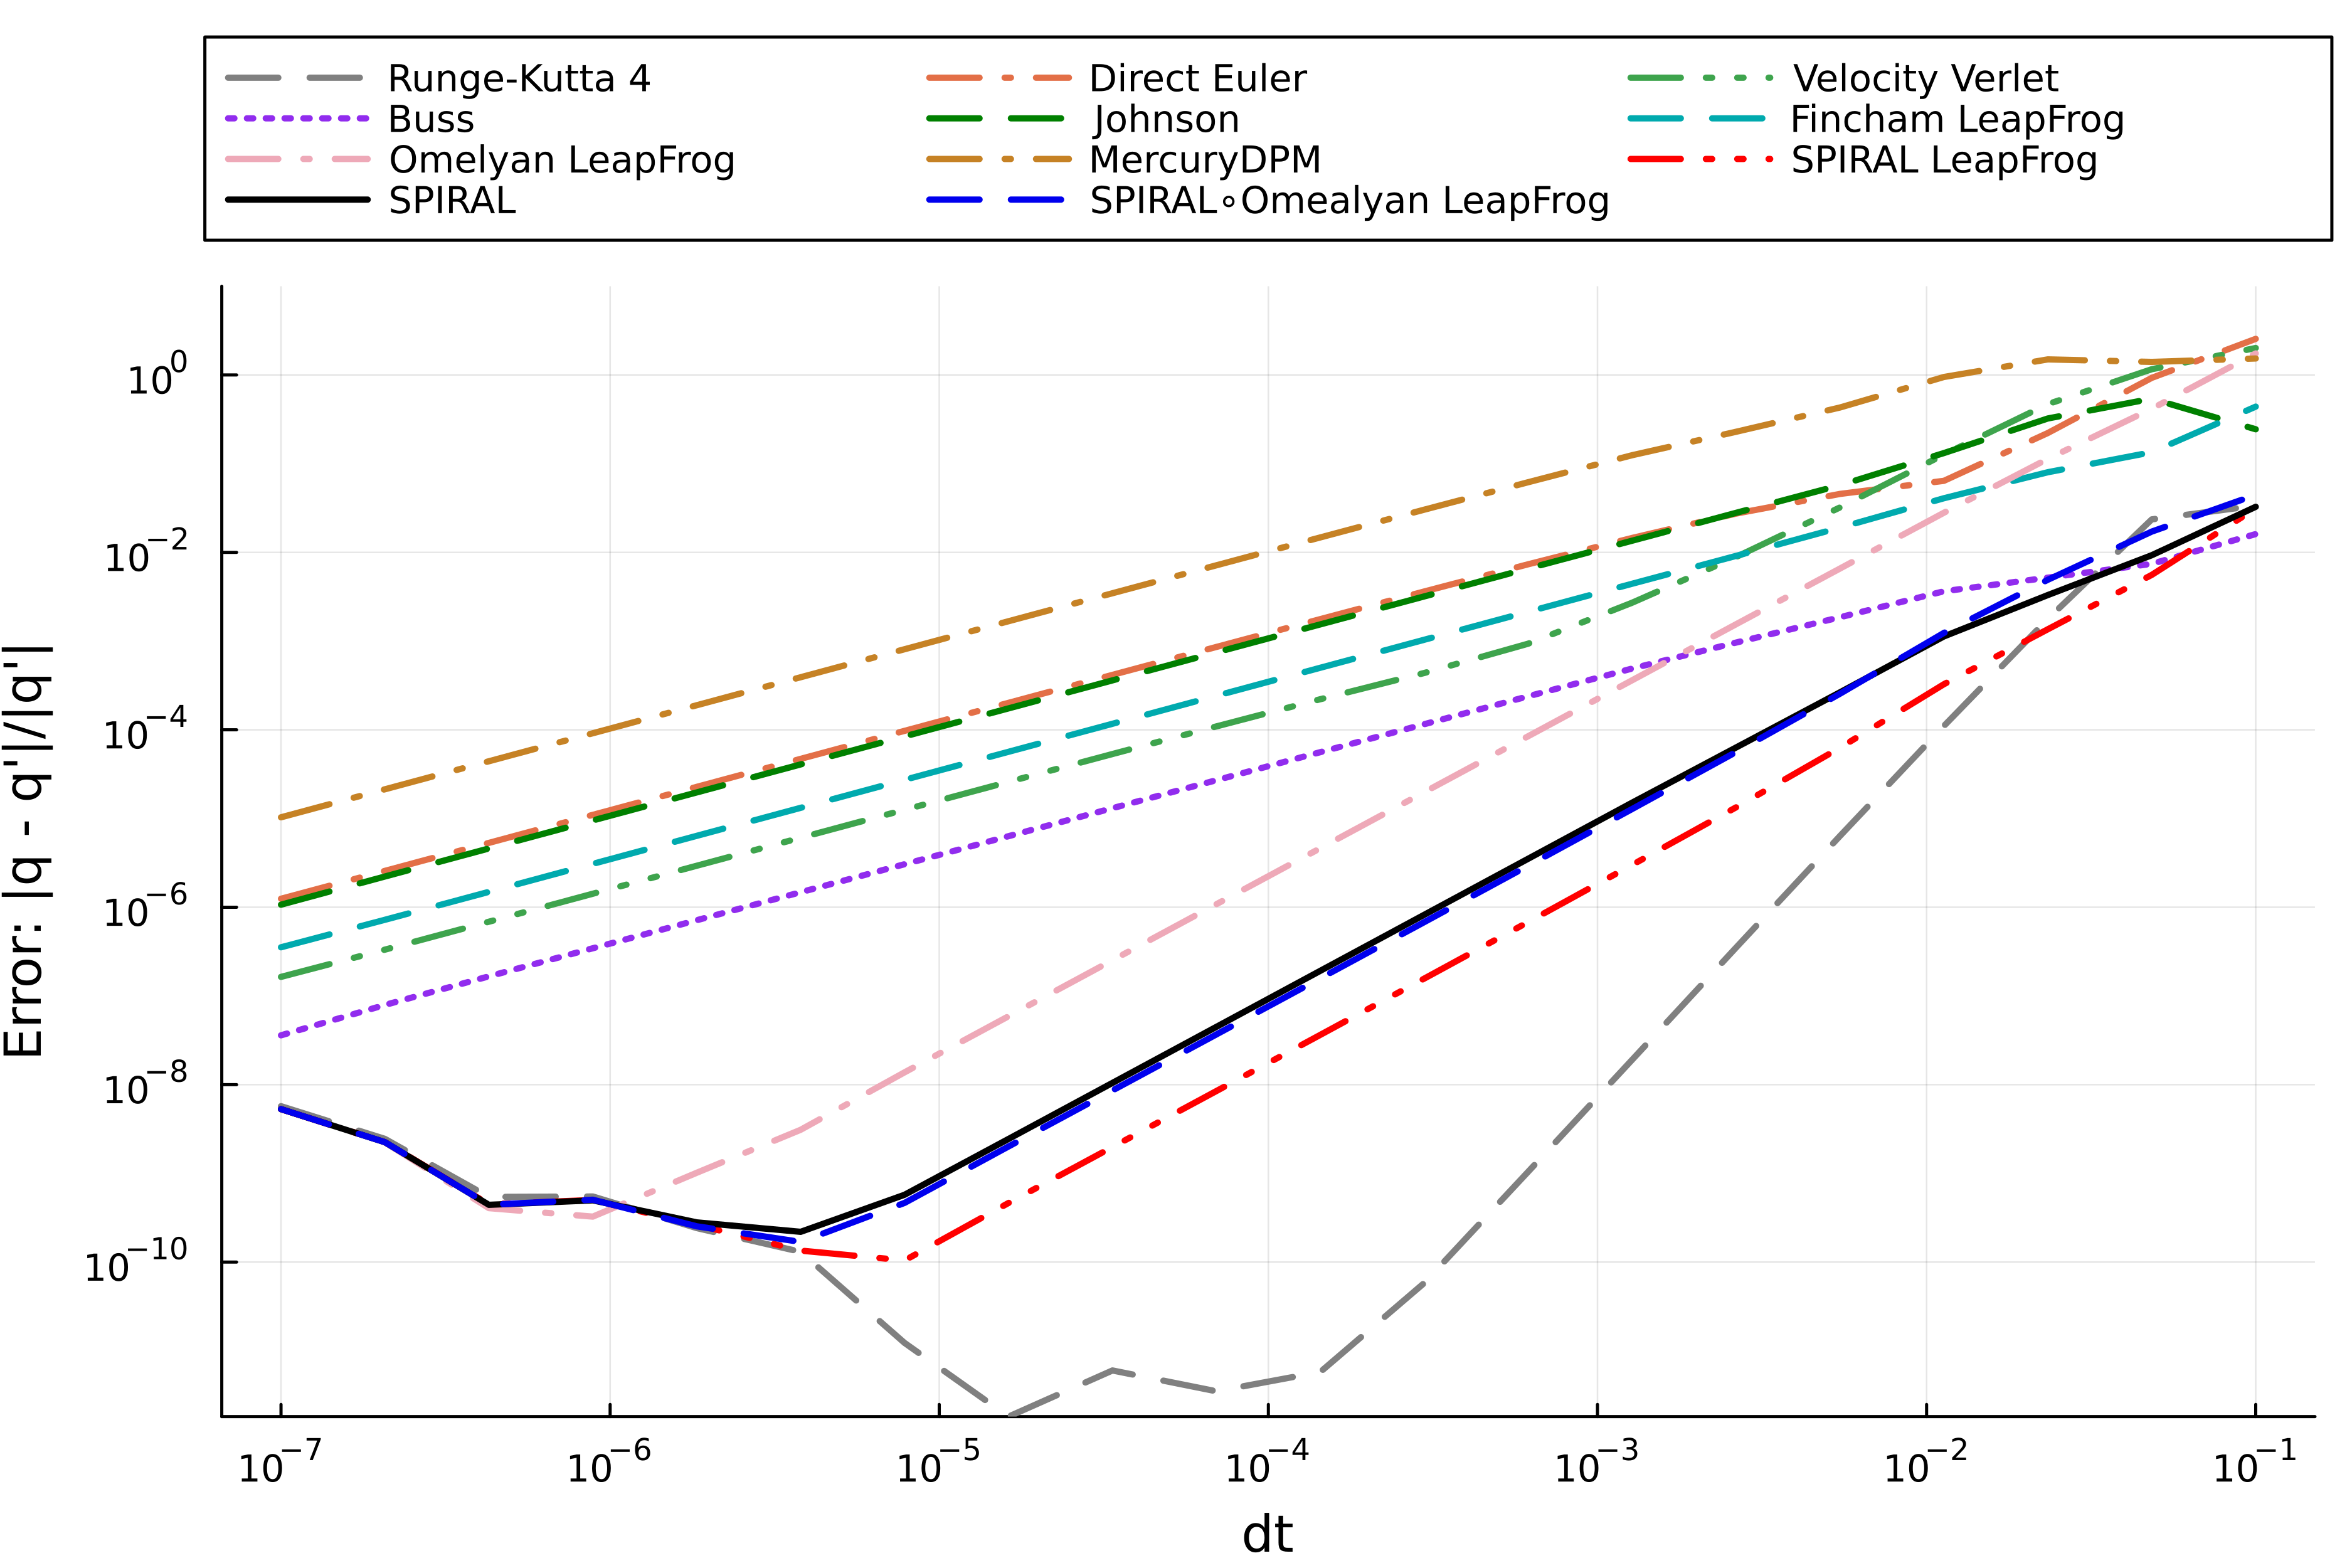

In [32]:
fig = plot(ylabel="Error: |q - q'|/|q'|", xlabel="dt", xscale=:log10, yscale=:log10, legend=:outertop, legend_columns=3, size=(750, 500), dpi=500)
plot!(dts1, Errors1[:,1], label="Runge-Kutta 4", linewidth=2, color=:gray, linestyle=:dash)
plot!(dts1, Errors1[:,2], label="Direct Euler", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,3], label="Velocity Verlet", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,4], label="Buss", linewidth=2, color=:purple2, linestyle=:auto)
plot!(dts1, Errors1[:,5], label="Johnson", linewidth=2, color=:green, linestyle=:dash)
plot!(dts1, Errors1[:,6], label="Fincham LeapFrog", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,7], label="Omelyan LeapFrog", linewidth=2, color=:pink2, linestyle=:auto)
plot!(dts1, Errors1[:,8], label="MercuryDPM", linewidth=2, color=:auto, linestyle=:dashdot)
plot!(dts1, Errors1[:,9], label="SPIRAL LeapFrog", linewidth=2, color=:red, linestyle=:dashdotdot)
plot!(dts1, Errors1[:,10], label="SPIRAL", linewidth=2, color=:black, linestyle=:auto)
plot!(dts1, Errors1[:,11], label="SPIRAL∘Omealyan LeapFrog", linewidth=2, color=:blue2, linestyle=:auto)
xticks!(10 .^ range(-8, 0, length=9))
yticks!(10 .^ range(-26, 4, length=16))
ylims!(-Inf,10)

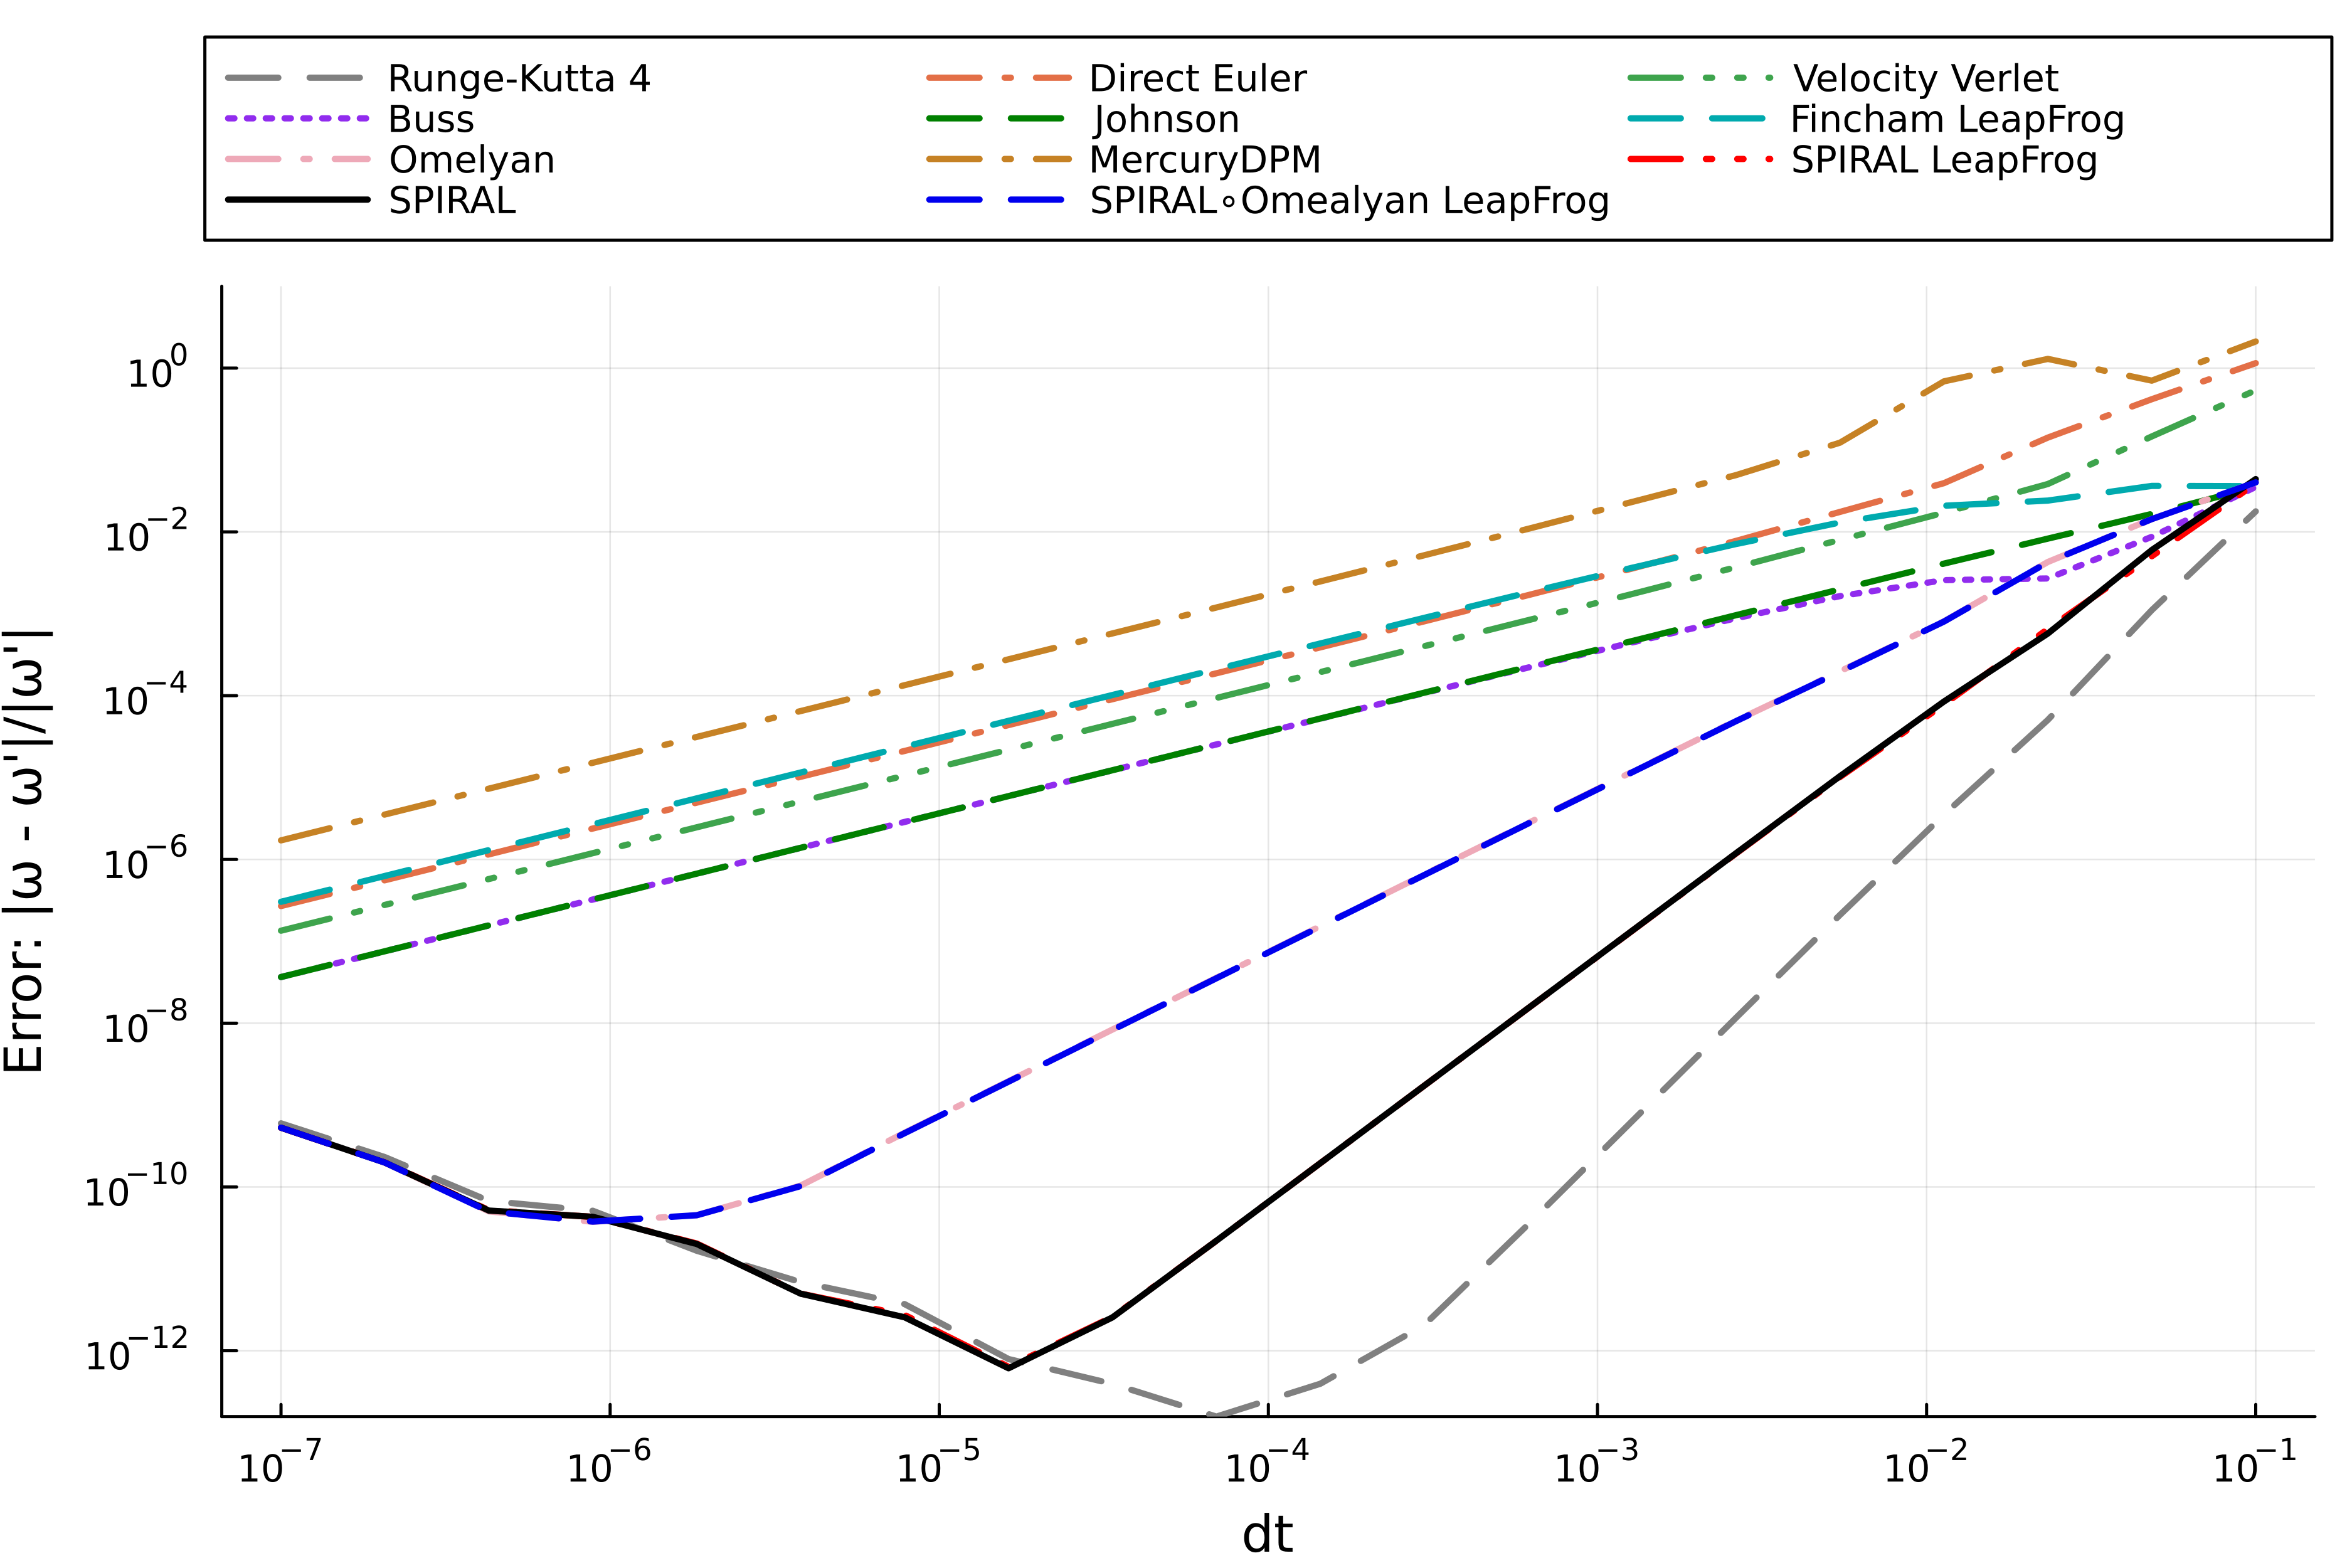

In [33]:
fig = plot(ylabel="Error: |ω - ω'|/|ω'|", xlabel="dt", xscale=:log10, yscale=:log10, legend=:outertop, legend_columns=3, size=(750, 500), dpi=500)
plot!(dts1, Errors1[:,12], label="Runge-Kutta 4", linewidth=2, color=:gray, linestyle=:dash)
plot!(dts1, Errors1[:,13], label="Direct Euler", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,14], label="Velocity Verlet", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,15], label="Buss", linewidth=2, color=:purple2, linestyle=:auto)
plot!(dts1, Errors1[:,16], label="Johnson", linewidth=2, color=:green, linestyle=:dash)
plot!(dts1, Errors1[:,17], label="Fincham LeapFrog", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,18], label="Omelyan", linewidth=2, color=:pink2, linestyle=:auto)
plot!(dts1, Errors1[:,19], label="MercuryDPM", linewidth=2, color=:auto, linestyle=:dashdot)
plot!(dts1, Errors1[:,20], label="SPIRAL LeapFrog", linewidth=2, color=:red, linestyle=:dashdotdot)
plot!(dts1, Errors1[:,21], label="SPIRAL", linewidth=2, color=:black, linestyle=:auto)
plot!(dts1, Errors1[:,22], label="SPIRAL∘Omealyan LeapFrog", linewidth=2, color=:blue2, linestyle=:auto)
xticks!(10 .^ range(-8, 0, length=9))
yticks!(10 .^ range(-26, 4, length=16))
ylims!(-Inf,10)

In [34]:
header = ["dt", "RKq", "Eulerq", "Verletq", "Bussq", "Johnsonq", "Finchamq", "Omelyanq", 
    "MercuryDPMq", "SPIRALLq", "SPIRALq", "SPIRALOq", "RKw", "Eulerw", "Verletw", "Bussw", "Johnsonw", 
    "Finchamw", "Omelyanw", "MercuryDPMw", "SPIRALLw", "SPIRALw", "SPIRALOw"]
CSV.write("Data/Latex_dt_error.csv", DataFrame(hcat(dts1, Errors1), header))

"Data/Latex_dt_error"

----

# Plot Erros

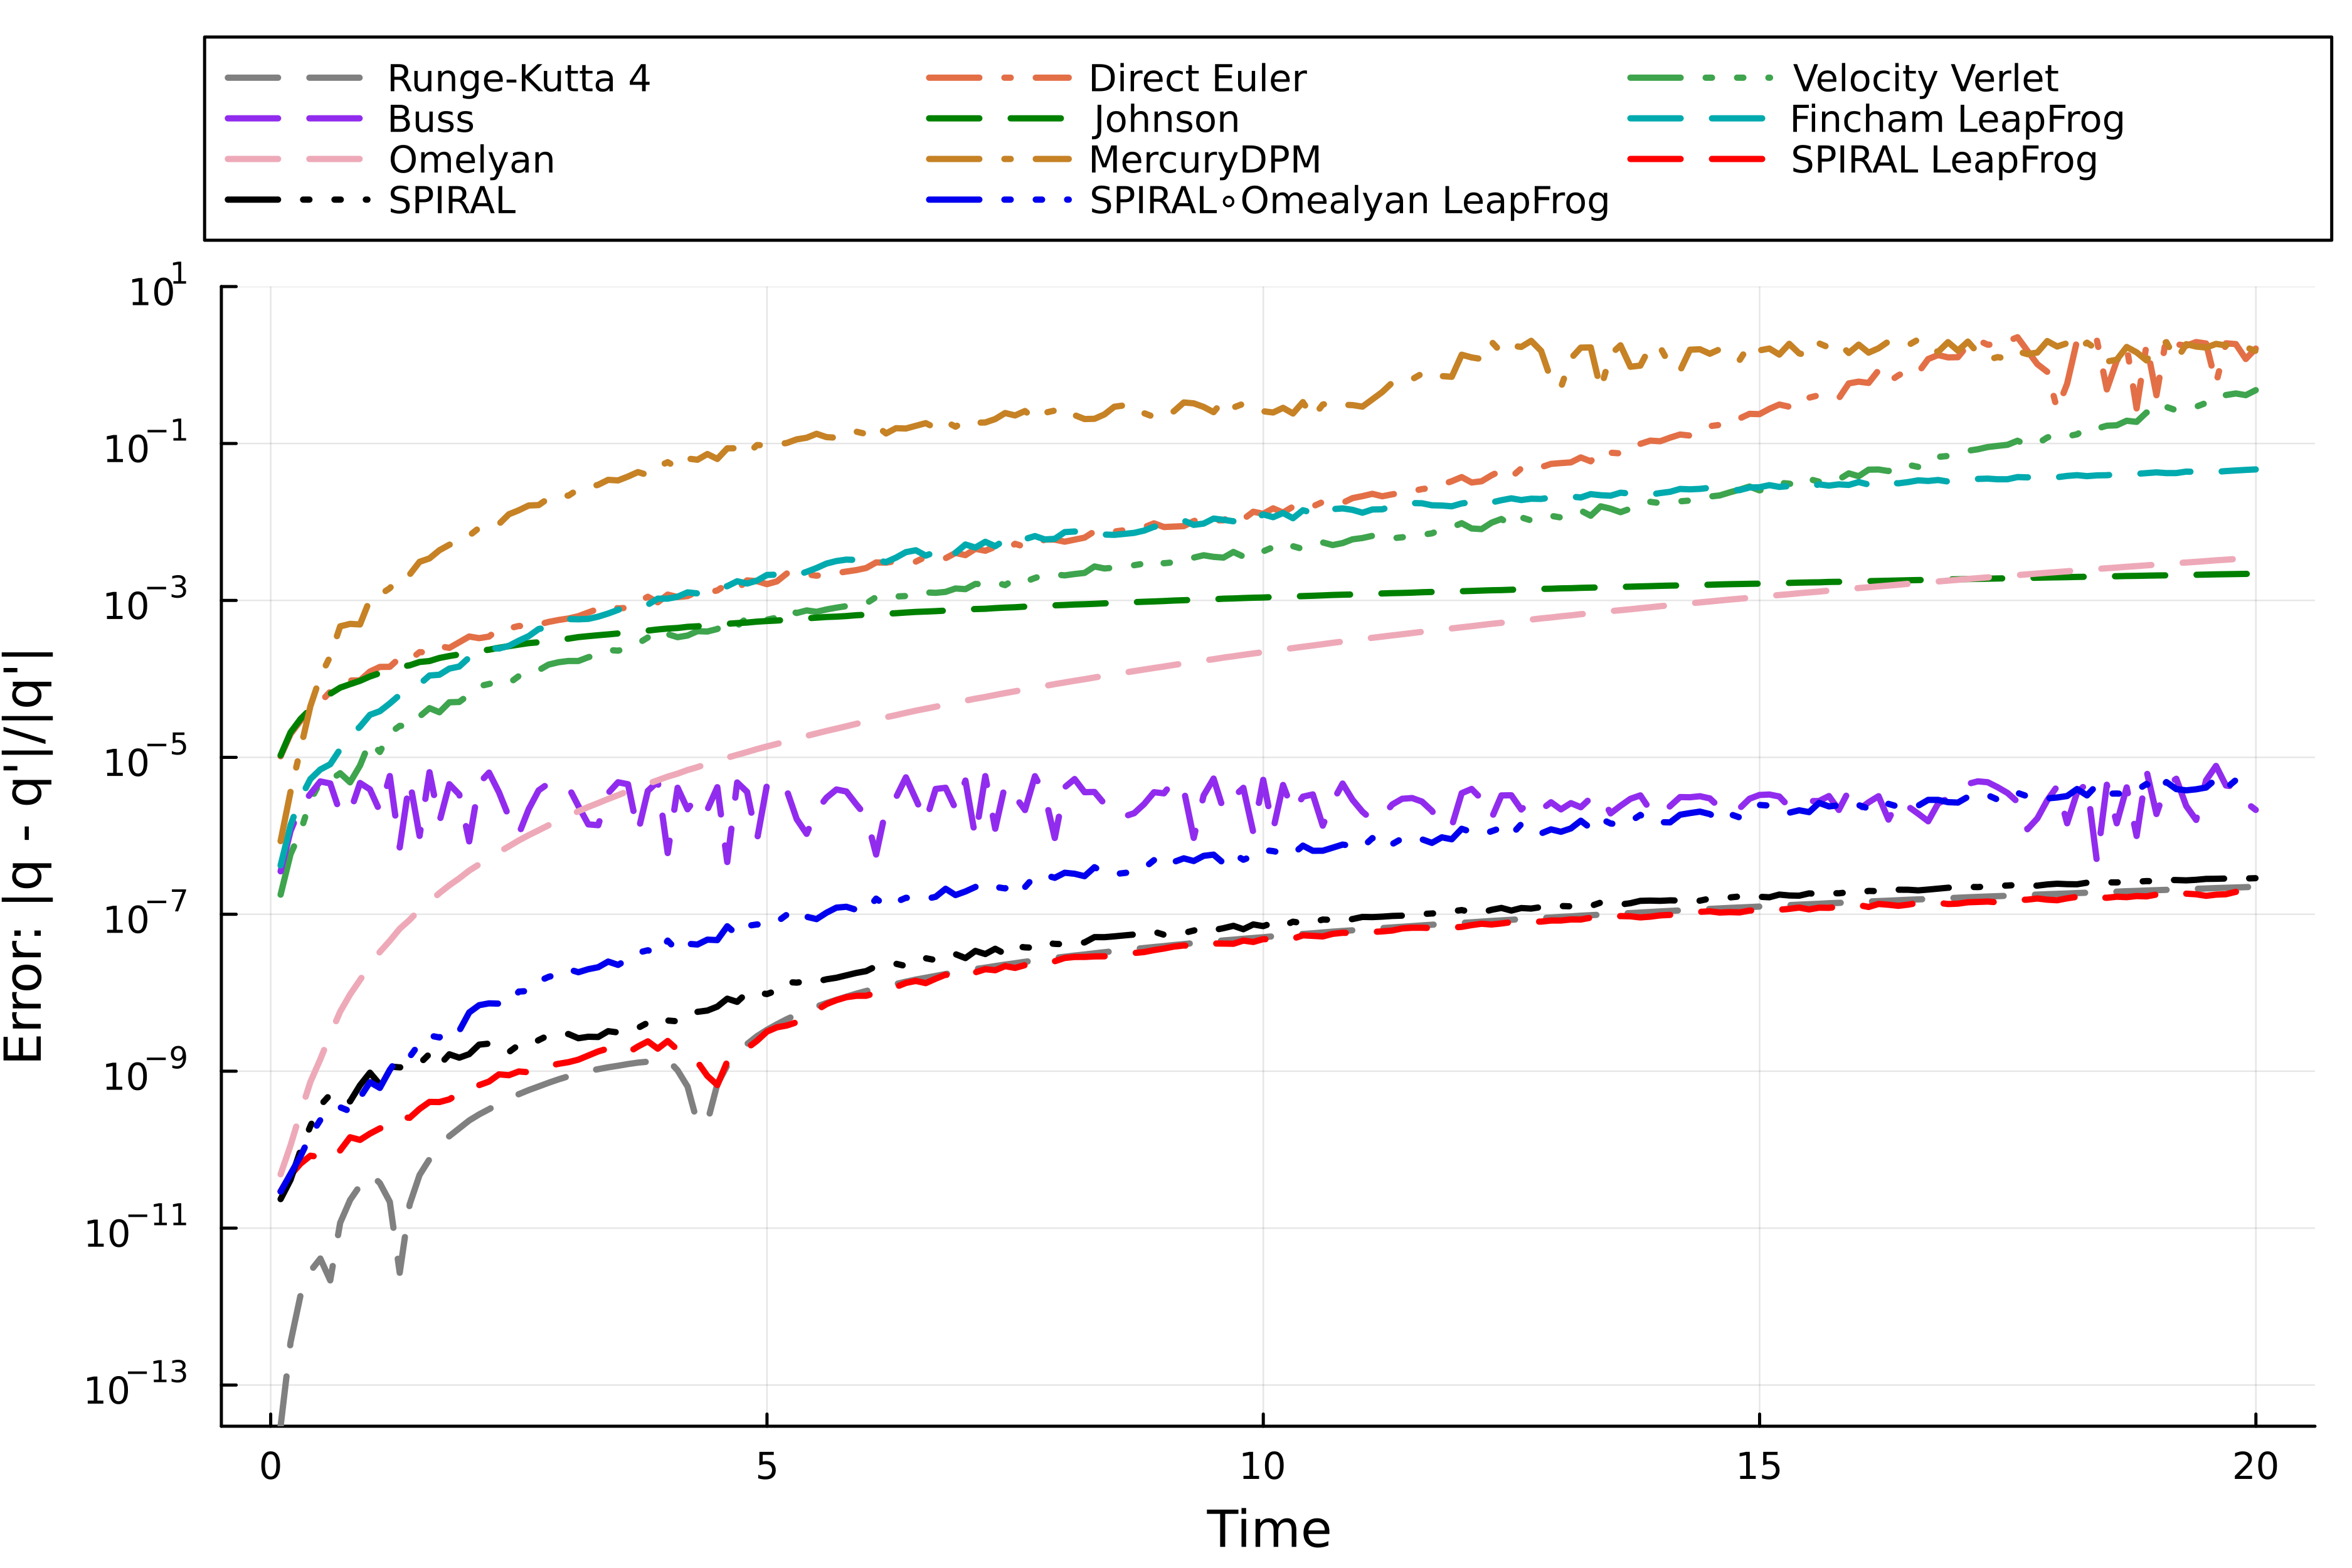

In [35]:
fig = plot(ylabel="Error: |q - q'|/|q'|", xlabel="Time", yscale=:log10, legend=:outertop, legend_columns=3, size=(750, 500), dpi=500)
plot!(Rkt4_Time, Rkt4_Error_q, label="Runge-Kutta 4", linewidth=2, color=:gray, linestyle=:dash)
plot!(Euler_Time, Euler_Error_q, label="Direct Euler", linewidth=2, color=:auto, linestyle=:auto)
plot!(Verlet_Time, Verlet_Error_q, label="Velocity Verlet", linewidth=2, color=:auto, linestyle=:auto)
plot!(Buss_Time, Buss_Error_q, label="Buss", linewidth=2, color=:purple2, linestyle=:dash)
plot!(Johnson_Time, Johnson_Error_q, label="Johnson", linewidth=2, color=:green, linestyle=:dash)
plot!(Fincham_Time, Fincham_Error_q, label="Fincham LeapFrog", linewidth=2, color=:auto, linestyle=:auto)
plot!(Omelyan_Time, Omelyan_Error_q, label="Omelyan", linewidth=2, color=:pink2, linestyle=:dash)
plot!(Mercury_Time, Mercury_Error_q, label="MercuryDPM", linewidth=2, color=:auto, linestyle=:dashdot)
plot!(SPIRAL_L_Time, SPIRAL_L_Error_q, label="SPIRAL LeapFrog", linewidth=2, color=:red, linestyle=:dash)
plot!(SPIRAL_Time, SPIRAL_Error_q, label="SPIRAL", linewidth=2, color=:black, linestyle=:dashdotdot)
plot!(SPIRAL_L_Time2, SPIRAL_L_Error_q2, label="SPIRAL∘Omealyan LeapFrog", linewidth=2, color=:blue2, linestyle=:dashdotdot)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))
ylims!(-Inf,10)

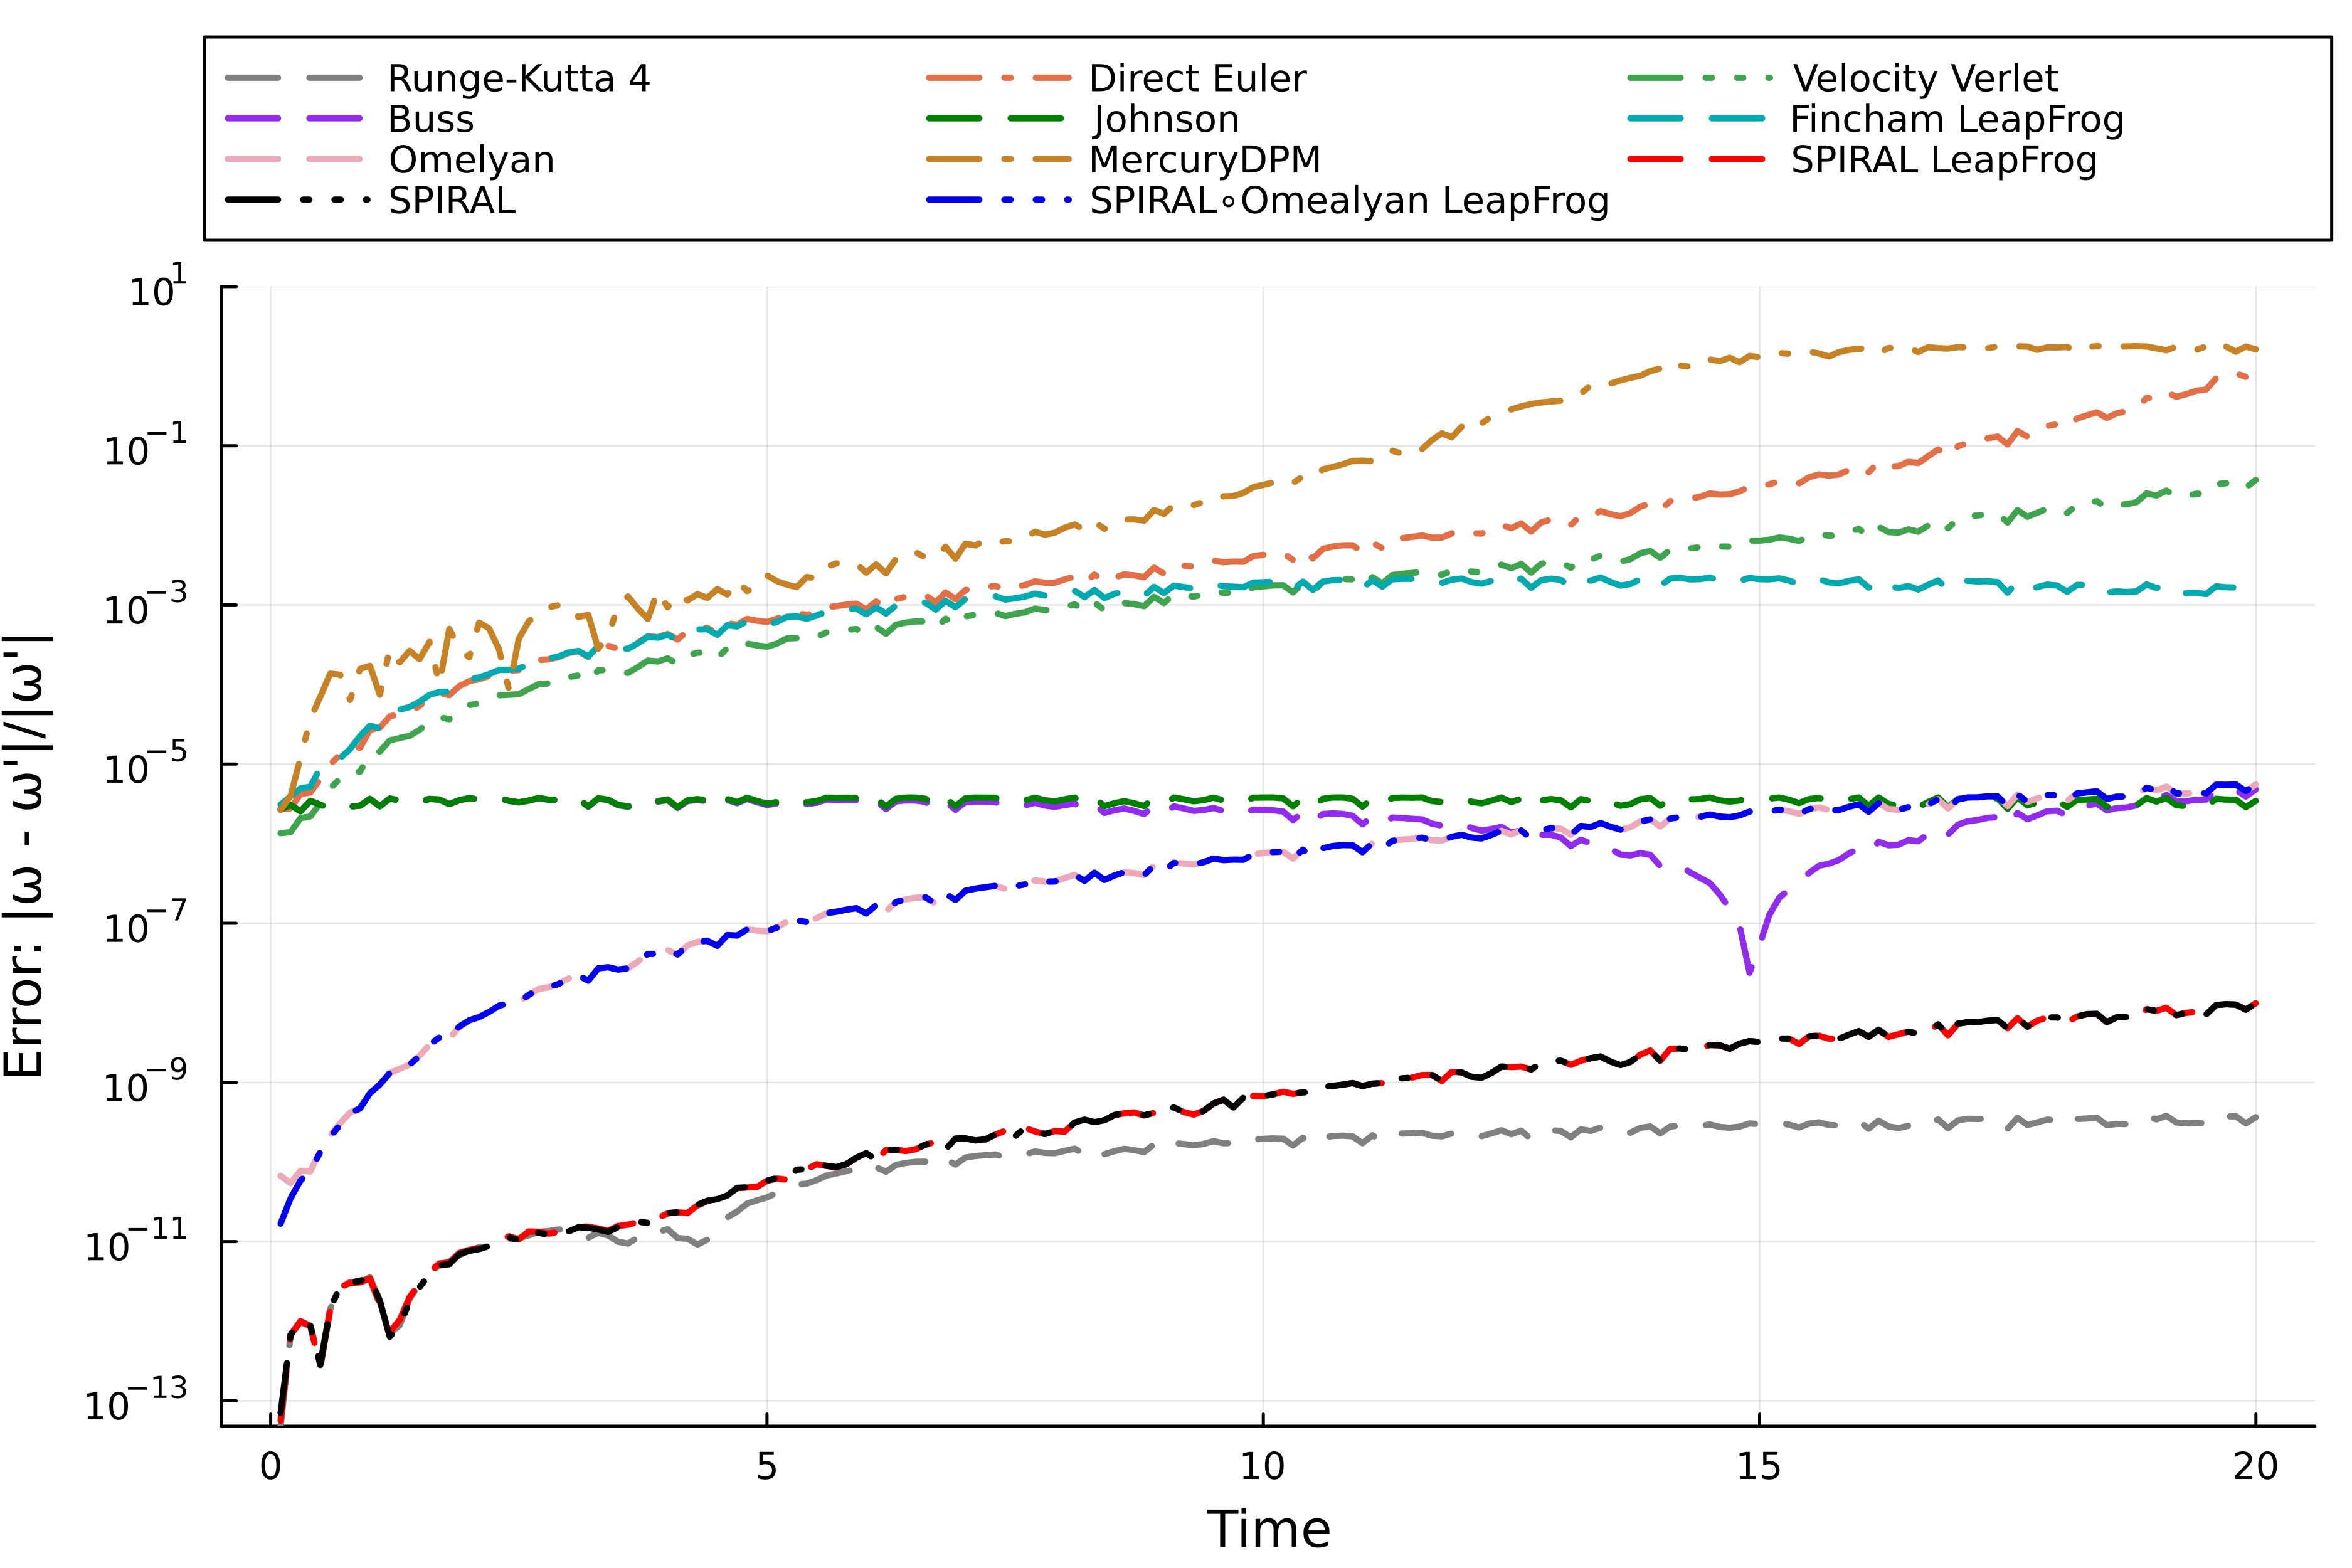

In [36]:
fig = plot(ylabel="Error: |ω - ω'|/|ω'|", xlabel="Time", yscale=:log10, legend=:outertop, legend_columns=3, size=(750, 500), dpi=500)
plot!(Rkt4_Time, Rkt4_Error_w, label="Runge-Kutta 4", linewidth=2, color=:gray, linestyle=:dash)
plot!(Euler_Time, Euler_Error_w, label="Direct Euler", linewidth=2, color=:auto, linestyle=:auto)
plot!(Verlet_Time, Verlet_Error_w, label="Velocity Verlet", linewidth=2, color=:auto, linestyle=:auto)
plot!(Buss_Time, Buss_Error_w, label="Buss", linewidth=2, color=:purple2, linestyle=:dash)
plot!(Johnson_Time, Johnson_Error_w, label="Johnson", linewidth=2, color=:green, linestyle=:dash)
plot!(Fincham_Time, Fincham_Error_w, label="Fincham LeapFrog", linewidth=2, color=:auto, linestyle=:auto)
plot!(Omelyan_Time, Omelyan_Error_w, label="Omelyan", linewidth=2, color=:pink2, linestyle=:dash)
plot!(Mercury_Time, Mercury_Error_w, label="MercuryDPM", linewidth=2, color=:auto, linestyle=:dashdot)
plot!(SPIRAL_L_Time, SPIRAL_L_Error_w, label="SPIRAL LeapFrog", linewidth=2, color=:red, linestyle=:dash)
plot!(SPIRAL_Time, SPIRAL_Error_w, label="SPIRAL", linewidth=2, color=:black, linestyle=:dashdotdot)
plot!(SPIRAL_L_Time2, SPIRAL_L_Error_w2, label="SPIRAL∘Omealyan LeapFrog", linewidth=2, color=:blue2, linestyle=:dashdotdot)
#plot!(Rkt_Time, Rkt_Error_w .+ 1e-31, label="DifferentialEquations.jl", linewidth=1.5, color=:gray, linestyle=:solid)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))
ylims!(-Inf,10)

In [37]:
df = DataFrame(
    Rkt4_Time = Rkt4_Time,
    Rkt4_Error_w = Rkt4_Error_w,
    Rkt4_Error_q = Rkt4_Error_q,
    Euler_Time = Euler_Time,
    Euler_Error_w = Euler_Error_w,
    Euler_Error_q = Euler_Error_q,
    Verlet_Time = Verlet_Time,
    Verlet_Error_w = Verlet_Error_w,
    Verlet_Error_q = Verlet_Error_q,
    Buss_Time = Buss_Time,
    Buss_Error_w = Buss_Error_w,
    Buss_Error_q = Buss_Error_q,
    Johnson_Time = Johnson_Time,
    Johnson_Error_w = Johnson_Error_w,
    Johnson_Error_q = Johnson_Error_q,
    Fincham_Time = Fincham_Time,
    Fincham_Error_w = Fincham_Error_w,
    Fincham_Error_q = Fincham_Error_q,
    Omelyan_Time = Omelyan_Time,
    Omelyan_Error_w = Omelyan_Error_w,
    Omelyan_Error_q = Omelyan_Error_q,
    Mercury_Time = Mercury_Time,
    Mercury_Error_w = Mercury_Error_w,
    Mercury_Error_q = Mercury_Error_q,
    SPIRAL_L_Time = SPIRAL_L_Time,
    SPIRAL_L_Error_w = SPIRAL_L_Error_w,
    SPIRAL_L_Error_q = SPIRAL_L_Error_q,
    SPIRAL_Time = SPIRAL_Time,
    SPIRAL_Error_w = SPIRAL_Error_w,
    SPIRAL_Error_q = SPIRAL_Error_q,
    SPIRAL_L_Time2 = SPIRAL_L_Time2,
    SPIRAL_L_Error_w2 = SPIRAL_L_Error_w2,
    SPIRAL_L_Error_q2 = SPIRAL_L_Error_q2,
    Rkt_Time = Rkt_Time,
    Rkt_Error_w = Rkt_Error_w .+ 1e-31,
    Rkt_Error_q = Rkt_Error_q
)

# Save the DataFrame to a CSV file
CSV.write("Data/qw_error_time.csv", df)

"Data/qw_error_time.csv"

----

# Stability and Energy Conservation

We have 30 multispheres bouncing on a box without damping, friction and gravity. We then can compare the energy conservation capabilities of the different algorithms. The simulations were performed in YADE and MercuryDMP. 

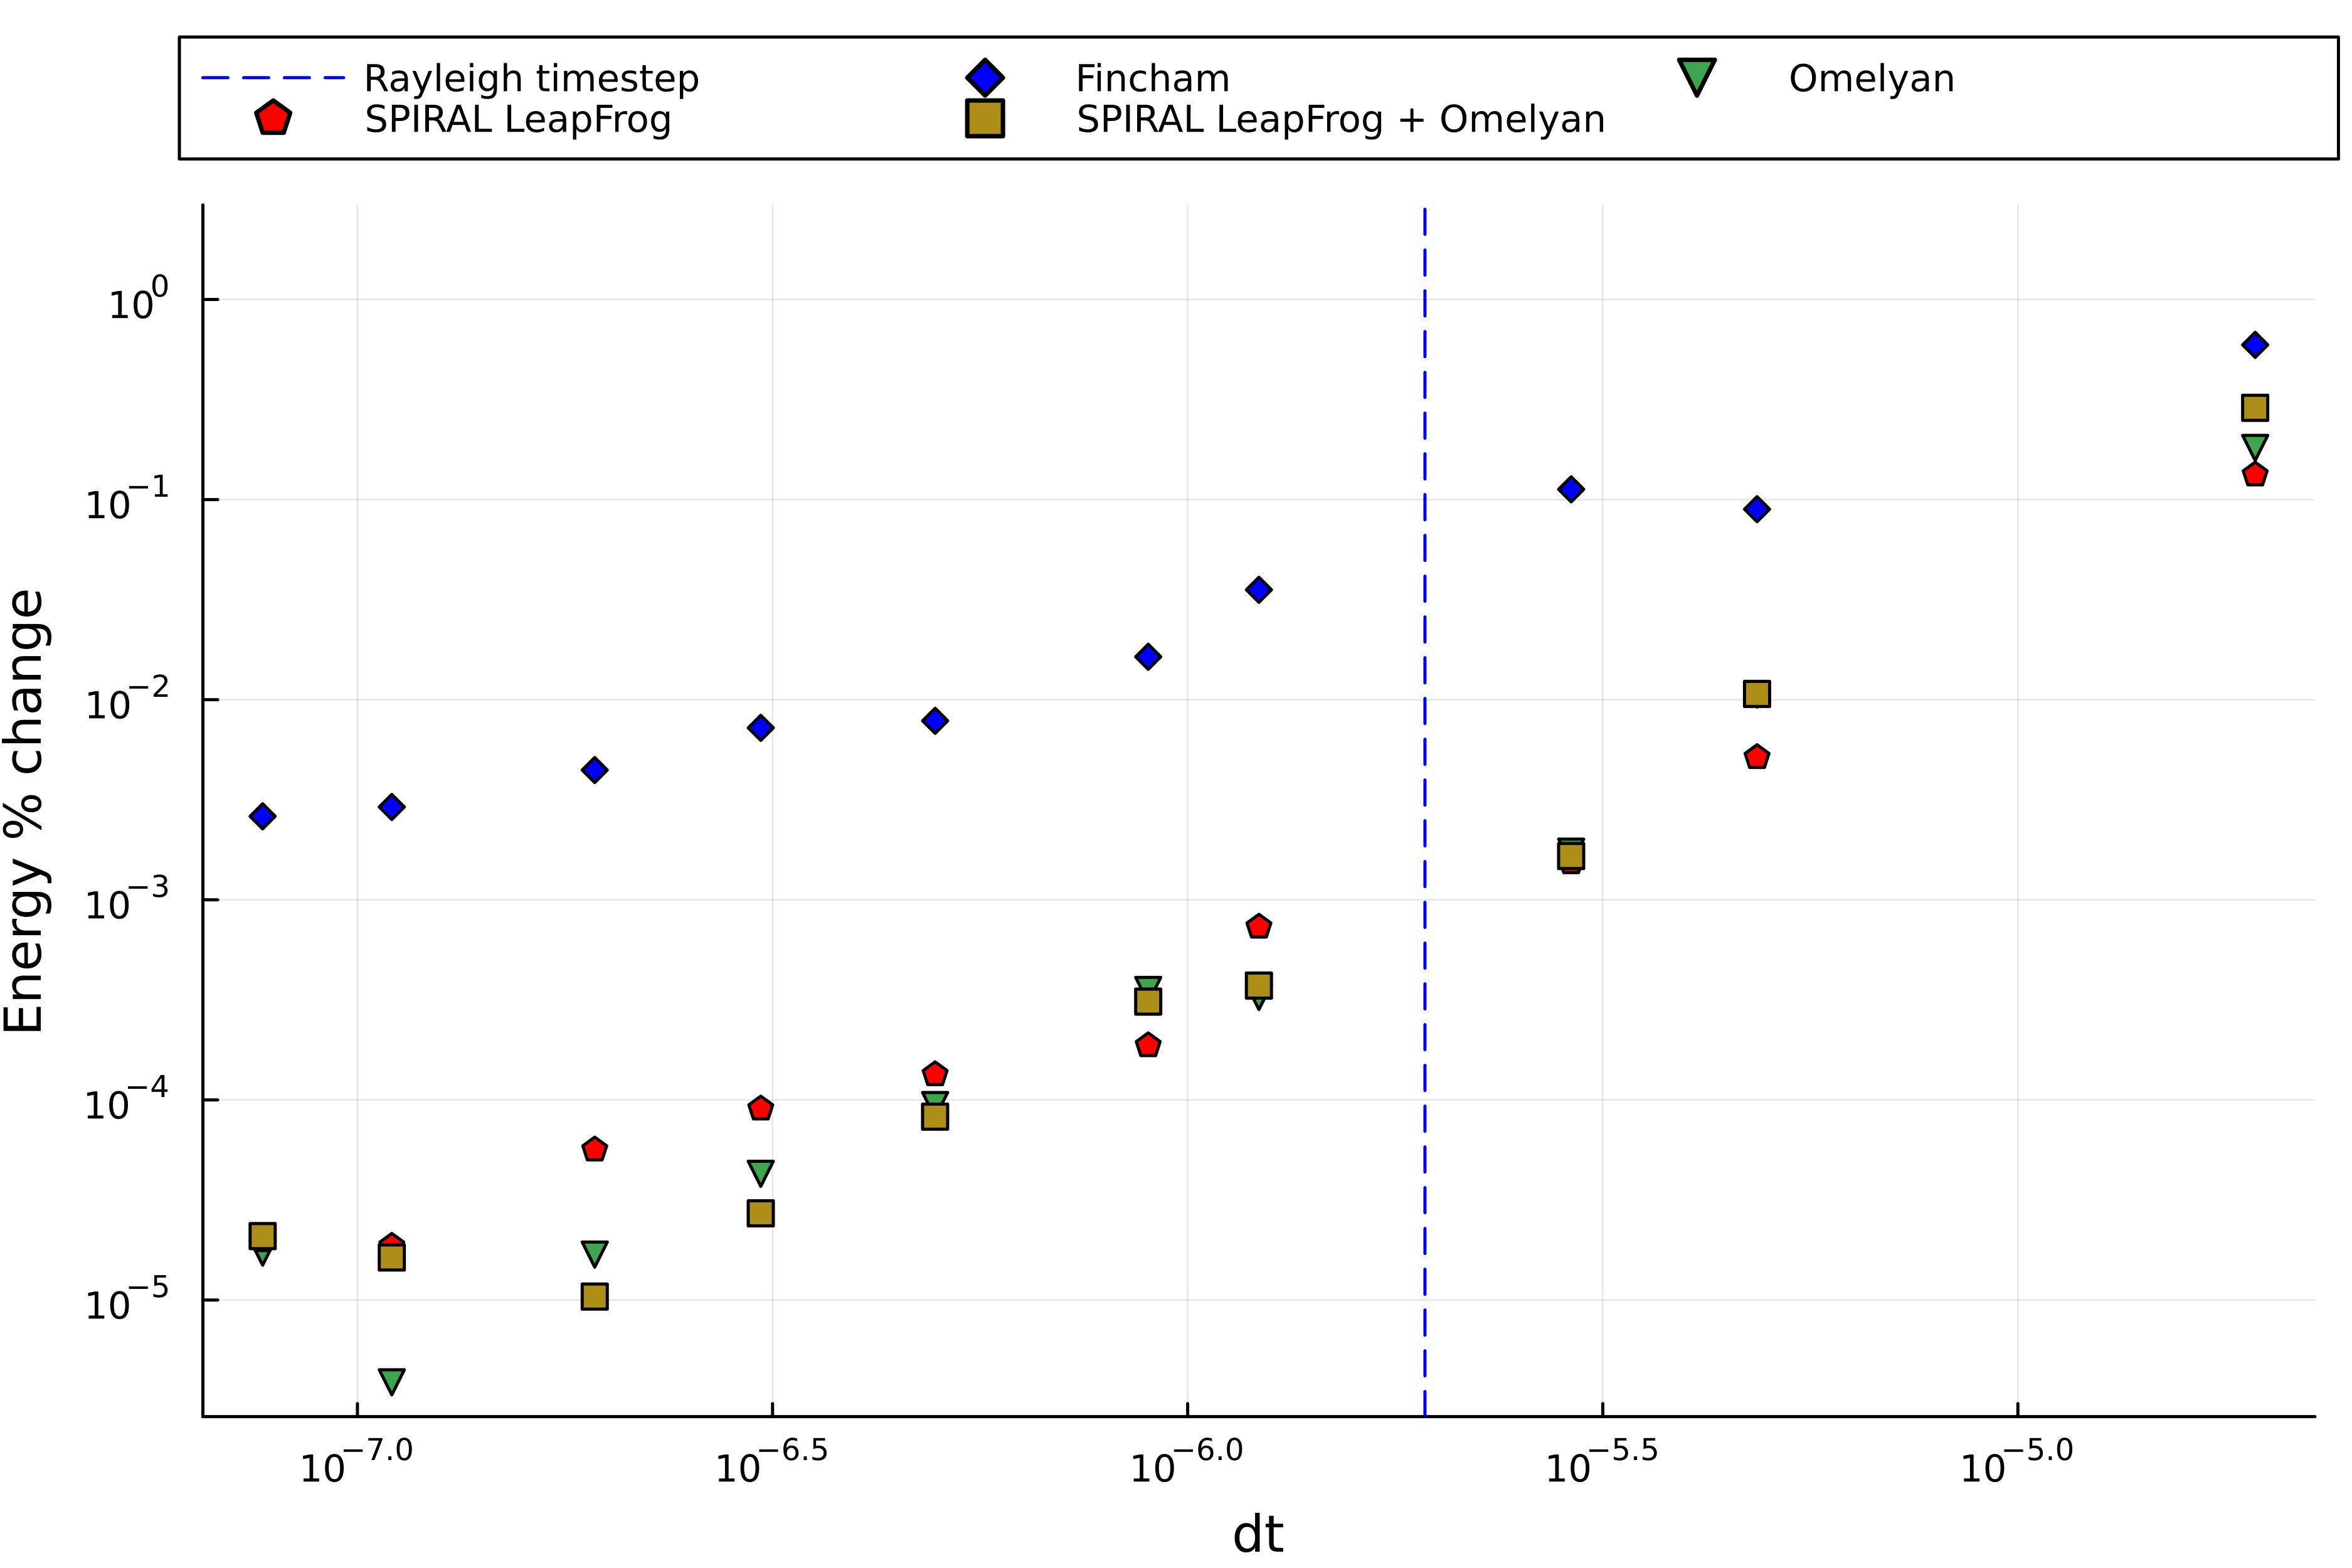

In [38]:
df1 = CSV.read("Data/Fincham_energy.csv", DataFrame, header=true, comment="#")
M1 = Matrix(df1)
df2 = CSV.read("Data/Omelyan98_energy.csv", DataFrame, header=true, comment="#")
M2 = Matrix(df2)
df3 = CSV.read("Data/Carlos_2023_energy.csv", DataFrame, header=true, comment="#")
M3 = Matrix(df3)
df4 = CSV.read("Data/Carlos_Omelyan_2023_energy.csv", DataFrame, header=true, comment="#")
M4 = Matrix(df4)

fig = plot(xscale=:log10, yscale=:log10, ylabel="Energy % change", legend=:outertop, legend_columns=3, size=(750, 500), dpi=500)
vline!([1.9311703796025776e-06], line=:dash, linecolor=:blue2, label="Rayleigh timestep")
scatter!(M1[:, 1], M1[:, 2], xlabel="dt", label="Fincham", color=:blue, markershape=:diamond)
scatter!(M2[:, 1], M2[:, 2], label="Omelyan", markershape=:dtriangle)
scatter!(M3[:, 1], M3[:, 2], label="SPIRAL LeapFrog", markershape=:pentagon, color=:red)
scatter!(M4[:, 1], M4[:, 2], label="SPIRAL LeapFrog + Omelyan", markershape=:square, color=:auto)
xticks!(10 .^ range(-8, 0, length=17))
yticks!(10 .^ range(-20, 4, length=25))

In [39]:
df = DataFrame(
    Time_Fincham = M1[:, 1],
    Time_Omelyan = M2[:, 1],
    Time_SPIRAL = M3[:, 1],
    Time_SPIRALO = M4[:, 1],
    Fincham = M1[:, 2],
    Omelyan = M2[:, 2],
    SPIRAL = M3[:, 2],
    SPIRALO = M4[:, 2]
)

# Save the DataFrame to a CSV file
CSV.write("Data/Energy.csv", df)

"Data/Energy.csv"

----

# Performance:

In [40]:
Norm = true
Benchmark_Rkt4 = @benchmark $Rkt4_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_Euler = @benchmark $Direct_Euler_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_Verlet = @benchmark $Verlet_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_Buss = @benchmark $Buss_Step($q0, $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
Benchmark_Johnson = @benchmark $Johnson_Step($q0, $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
Benchmark_Fincham = @benchmark $Fincham_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_Omelyan = @benchmark $Omelyan_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_Mercury = @benchmark $Mercury_step($quat_to_dcm(q0), $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
Benchmark_SPIRAL = @benchmark $SPIRAL_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_SPIRALL = @benchmark $SPIRAL_LeapFrog_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_SPIRALL2 = @benchmark $SPIRAL_LeapFrog_Step2($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)

Norm = false
NBenchmark_Rkt4 = @benchmark $Rkt4_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_Euler = @benchmark $Direct_Euler_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_Verlet = @benchmark $Verlet_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_Buss = @benchmark $Buss_Step($q0, $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
NBenchmark_Johnson = @benchmark $Johnson_Step($q0, $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
NBenchmark_Fincham = @benchmark $Fincham_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_Omelyan = @benchmark $Omelyan_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_Mercury = @benchmark $Mercury_step($quat_to_dcm(q0), $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
NBenchmark_SPIRAL = @benchmark $SPIRAL_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_SPIRALL = @benchmark $SPIRAL_LeapFrog_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_SPIRALL2 = @benchmark $SPIRAL_LeapFrog_Step2($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm);

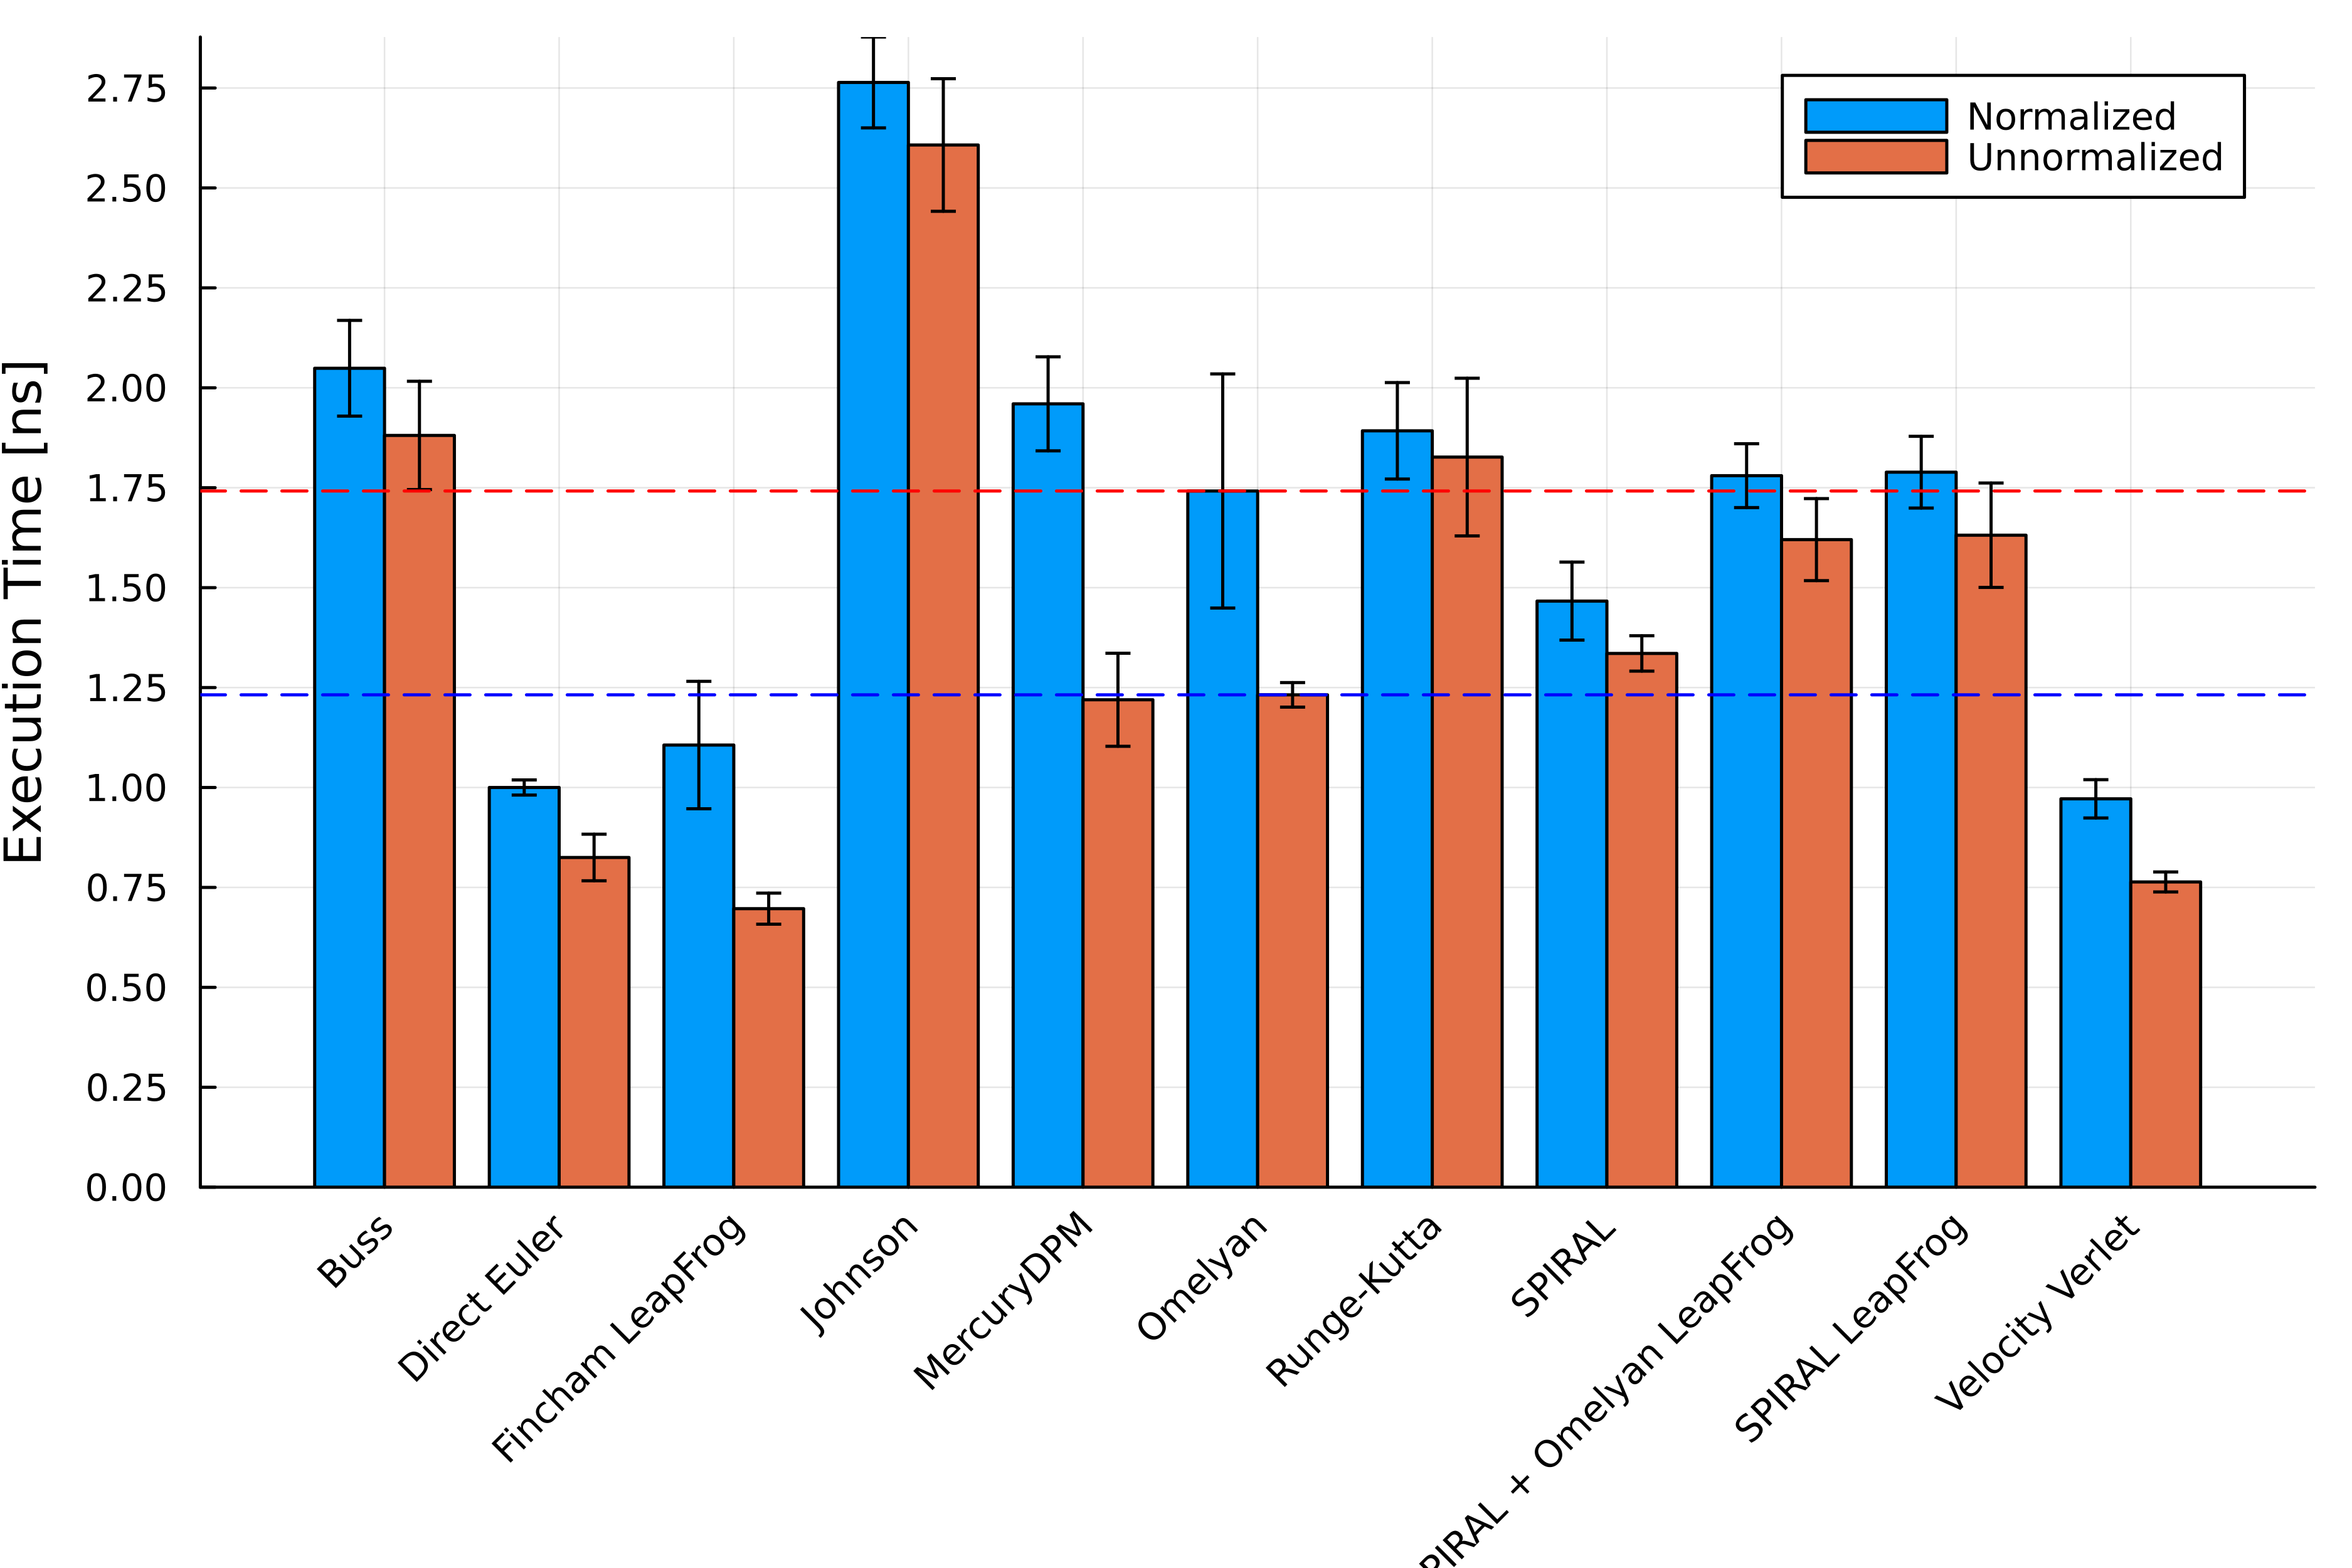

In [41]:
# Get results
results = [
    Benchmark_Euler.times, NBenchmark_Euler.times,
    Benchmark_Omelyan.times, NBenchmark_Omelyan.times,
    Benchmark_Verlet.times, NBenchmark_Verlet.times,
    Benchmark_Buss.times, NBenchmark_Buss.times,
    Benchmark_Fincham.times, NBenchmark_Fincham.times,
    Benchmark_Johnson.times, NBenchmark_Johnson.times,
    Benchmark_Mercury.times, NBenchmark_Mercury.times,
    Benchmark_Rkt4.times, NBenchmark_Rkt4.times,
    Benchmark_SPIRAL.times, NBenchmark_SPIRAL.times,
    Benchmark_SPIRALL.times, NBenchmark_SPIRALL.times,
    Benchmark_SPIRALL2.times, NBenchmark_SPIRALL2.times
]

# Names of the results
labels = [
    "Direct Euler", "Direct Euler", 
    "Omelyan", "Omelyan",
    "Velocity Verlet", "Velocity Verlet", 
    "Buss", "Buss", 
    "Fincham LeapFrog", "Fincham LeapFrog", 
    "Johnson", "Johnson", 
    "MercuryDPM", "MercuryDPM",
    "Runge-Kutta", "Runge-Kutta",
    "SPIRAL", "SPIRAL",
    "SPIRAL LeapFrog", "SPIRAL LeapFrog",
    "SPIRAL + Omelyan LeapFrog", "SPIRAL + Omelyan LeapFrog"
]

Len = trunc(Int64, length(labels)/2)

# Calculate results statistics
means = mean.(results)
stds = std.(results)

# Normalize time
Reff_time = means[1]
means /= Reff_time
stds /= Reff_time

# Plot results
p = groupedbar(labels, means, yerr=stds, group = repeat(["Normalized", "Unnormalized"], outer=Len),
    xlabel="Method", ylabel="Execution Time [ns]", legend=:topright,
    xrotation=45, size=(750, 500), dpi=500)
hline!([means[3]], line=:dash, linecolor=:red, label="")
yticks!([yticks(p)[1][1]..., round(means[3], digits=4)])
hline!([means[4]], line=:dash, linecolor=:blue, label="")
yticks!([yticks(p)[1][1]..., round(means[4], digits=2)])

yticks!(range(0.0, 3.5, length=15))

----

<font color='red'>
Warning: When looking at this plot, remember that the Runge-Kutta time is greatly idealized. In this toy example, we have a constant torque, but in a real-case scenario, it would need to calculate forces 4 times. Calculating forces implies iterating over all the particles. The other algorithms only do it 1 time. 
</font>

---

In [70]:
labels = [
    "Direct Euler",
    "Omelyan",
    "Velocity Verlet",
    "Buss",
    "Fincham LeapFrog",
    "Johnson",
    "MercuryDPM",
    "SPIRAL",
]

results = [
    Benchmark_Euler.times, NBenchmark_Euler.times,
    Benchmark_Omelyan.times, NBenchmark_Omelyan.times,
    Benchmark_Verlet.times, NBenchmark_Verlet.times,
    Benchmark_Buss.times, NBenchmark_Buss.times,
    Benchmark_Fincham.times, NBenchmark_Fincham.times,
    Benchmark_Johnson.times, NBenchmark_Johnson.times,
    Benchmark_Mercury.times, NBenchmark_Mercury.times,
    Benchmark_SPIRAL.times, NBenchmark_SPIRAL.times,
]

# Calculate results statistics
means = mean.(results)
stds = std.(results)

# Normalize time
Reff_time = means[1]
means /= Reff_time
stds /= Reff_time


df = DataFrame(
    Method = chomp.(labels),
    TimeN = means[1:2:end],
    ErrorN = stds[1:2:end],
    Time = means[2:2:end],
    Error = stds[2:2:end]
)

# Save the DataFrame to a CSV file
CSV.write("Data/bar_plot_data.csv", df)

"Data/bar_plot_data.csv"

# Speed UP

In [43]:
function Error_dt(DT::Float64, args)::Float64
    interpol_method, target_error = args
    return 10^interpol_method(DT) - target_error
end

function CPU_time_for_error(interpol_method, integration_method, target_error::Float64, Tmax::Float64)
    DT = 10^find_zero(Error_dt, (-8, -1), (interpol_method, target_error))
    
    Benchmark = @benchmark $integration_method($Tmax, $DT, $1)
    return DT, mean(Benchmark.times)
end

function Generate_Speed_Up_Results(target_error::Float64; Tmax::Float64=1.0)
    # Create interpolator for the error
    dt_log = @. log10(dts1)
    dt_range = range(dt_log[1], stop=dt_log[end], length=length(dt_log))
    
    Euler_avg = @. log10(0.5*(Errors1[:,2] + Errors1[:,13]))
    interp_Euler = linear_interpolation(dt_range, Euler_avg, extrapolation_bc=Linear()) 
    
    Verlet_avg = @. log10(0.5*(Errors1[:,3] + Errors1[:,14]))
    interp_Verlet = linear_interpolation(dt_range, Verlet_avg, extrapolation_bc=Linear()) 
    
    Buss_avg = @. log10(0.5*(Errors1[:,4] + Errors1[:,15]))
    interp_Buss = linear_interpolation(dt_range, Buss_avg, extrapolation_bc=Linear()) 
    
    Johnson_avg = @. log10(0.5*(Errors1[:,5] + Errors1[:,16]))
    interp_Johnson = linear_interpolation(dt_range, Johnson_avg, extrapolation_bc=Linear()) 

    Fincham_avg = @. log10(0.5*(Errors1[:,6] + Errors1[:,17]))
    interp_Fincham = linear_interpolation(dt_range, Fincham_avg, extrapolation_bc=Linear())
    
    Omelyan_avg = @. log10(0.5*(Errors1[:,7] + Errors1[:,18]))
    interp_Omelyan = linear_interpolation(dt_range, Omelyan_avg, extrapolation_bc=Linear())
    
    MercuryDPM_avg = @. log10(0.5*(Errors1[:,8] + Errors1[:,19]))
    interp_MercuryDPM = linear_interpolation(dt_range, MercuryDPM_avg, extrapolation_bc=Linear())
    
    SPIRALL_avg = @. log10(0.5*(Errors1[:,9] + Errors1[:,20]))
    interp_SPIRALL = linear_interpolation(dt_range, SPIRALL_avg, extrapolation_bc=Linear())
    
    SPIRAL_avg = @. log10(0.5*(Errors1[:,10] + Errors1[:,21]))
    interp_SPIRAL = linear_interpolation(dt_range, SPIRAL_avg, extrapolation_bc=Linear())
    
    SPIRALO_avg = @. log10(0.5*(Errors1[:,11] + Errors1[:,22]))
    interp_SPIRALO = linear_interpolation(dt_range, SPIRALO_avg, extrapolation_bc=Linear())
    
    println("\nSped Up for target error = ", target_error, " and simulation time = ", Tmax, " s \n")    
    Euler_dt, Euler_t = CPU_time_for_error(interp_Euler, Direct_Euler_Simulation, target_error, Tmax)
    println("Euler time = ", round(Euler_t*1e-9, sigdigits=4), " s, used dt = ", @sprintf("%.3e", Euler_dt))
    Verlet_dt, Verlet_t = CPU_time_for_error(interp_Verlet, Verlet_Simulation, target_error, Tmax)
    println("Verlet Speed Up = x", round(Euler_t/Verlet_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Verlet_dt))
    Buss_dt, Buss_t = CPU_time_for_error(interp_Buss, Buss_Simulation, target_error, Tmax)
    println("Buss Speed Up = x", round(Euler_t/Buss_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Buss_dt))
    Johnson_dt, Johnson_t = CPU_time_for_error(interp_Johnson, Johnson_Simulation, target_error, Tmax)
    println("Johnson Speed Up = x", round(Euler_t/Johnson_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Johnson_dt))
    Fincham_dt, Fincham_t = CPU_time_for_error(interp_Fincham, Fincham_Simulation, target_error, Tmax)
    println("Fincham Speed Up = x", round(Euler_t/Fincham_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Fincham_dt))
    Omelyan_dt, Omelyan_t = CPU_time_for_error(interp_Omelyan, Omelyan_Simulation, target_error, Tmax)
    println("Omelyan Speed Up = x", round(Euler_t/Omelyan_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Omelyan_dt))
    Mercury_dt, Mercury_t = CPU_time_for_error(interp_MercuryDPM, Mercury_Simulation, target_error, Tmax)
    println("MercuryDMP Speed Up = x", round(Euler_t/Mercury_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Mercury_dt))
    SPIRAL_LeapFrog_dt, SPIRAL_LeapFrog_t = CPU_time_for_error(interp_SPIRALL, SPIRAL_LeapFrog_Simulation, target_error, Tmax)
    println("SPIRAL LeapFrog Speed Up = x", round(Euler_t/SPIRAL_LeapFrog_t, sigdigits=4), " used dt = ", @sprintf("%.3e", SPIRAL_LeapFrog_dt))
    SPIRAL_dt, SPIRAL_t = CPU_time_for_error(interp_SPIRAL, SPIRAL_Simulation, target_error, Tmax)
    println("SPIRAL Speed Up = x", round(Euler_t/SPIRAL_t, sigdigits=4), " used dt = ", @sprintf("%.3e", SPIRAL_dt))
   return nothing
end

Generate_Speed_Up_Results (generic function with 1 method)

In [44]:
Generate_Speed_Up_Results(1e-2)


Sped Up for target error = 0.01 and simulation time = 1.0 s 

Euler time = 6.032e-5 s, used dt = 1.421e-03
Verlet Speed Up = x2.288 used dt = 3.527e-03
Buss Speed Up = x10.25 used dt = 5.529e-02
Johnson Speed Up = x0.5482 used dt = 1.824e-03
Fincham Speed Up = x1.753 used dt = 3.295e-03
Omelyan Speed Up = x4.132 used dt = 9.400e-03
MercuryDMP Speed Up = x0.07247 used dt = 1.671e-04
SPIRAL LeapFrog Speed Up = x10.97 used dt = 6.167e-02
SPIRAL Speed Up = x10.92 used dt = 5.454e-02


In [45]:
Generate_Speed_Up_Results(1e-3)


Sped Up for target error = 0.001 and simulation time = 1.0 s 

Euler time = 0.0006113 s, used dt = 1.333e-04
Verlet Speed Up = x5.321 used dt = 6.779e-04
Buss Speed Up = x13.61 used dt = 2.890e-03
Johnson Speed Up = x0.5766 used dt = 1.804e-04
Fincham Speed Up = x1.959 used dt = 3.091e-04
Omelyan Speed Up = x15.03 used dt = 2.952e-03
MercuryDMP Speed Up = x0.07253 used dt = 1.663e-05
SPIRAL LeapFrog Speed Up = x69.49 used dt = 2.329e-02
SPIRAL Speed Up = x56.73 used dt = 1.543e-02


In [46]:
Generate_Speed_Up_Results(1e-4)


Sped Up for target error = 0.0001 and simulation time = 1.0 s 

Euler time = 0.005989 s, used dt = 1.325e-05
Verlet Speed Up = x5.383 used dt = 6.852e-05
Buss Speed Up = x12.44 used dt = 2.663e-04
Johnson Speed Up = x0.5691 used dt = 1.801e-05
Fincham Speed Up = x1.894 used dt = 3.071e-05
Omelyan Speed Up = x56.17 used dt = 9.319e-04
MercuryDMP Speed Up = x0.07118 used dt = 1.662e-06
SPIRAL LeapFrog Speed Up = x331.2 used dt = 8.372e-03
SPIRAL Speed Up = x226.0 used dt = 4.651e-03


In [47]:
Generate_Speed_Up_Results(1e-5)


Sped Up for target error = 1.0e-5 and simulation time = 1.0 s 

Euler time = 0.06036 s, used dt = 1.324e-06
Verlet Speed Up = x5.285 used dt = 6.789e-06
Buss Speed Up = x13.16 used dt = 2.650e-05
Johnson Speed Up = x0.58 used dt = 1.801e-06
Fincham Speed Up = x1.909 used dt = 3.069e-06
Omelyan Speed Up = x175.6 used dt = 2.943e-04
MercuryDMP Speed Up = x0.07111 used dt = 1.662e-07
SPIRAL LeapFrog Speed Up = x1371.0 used dt = 3.044e-03
SPIRAL Speed Up = x774.7 used dt = 1.462e-03


----

# Cylinder rendering

In [62]:
using GLMakie

In [63]:
function Create_Cylinders(i)
    # Get orientation
    Euler_q = Quaternion(Euler_Prediction[i,1:4])
    SPIRAL_LeapFrog_q = Quaternion(SPIRAL_L_Prediction[i,1:4])
    
    time = Euler_Time[i]
    Rkt_Q = Quaternion(Rkt_sol_q(time)[1:4])
    
    println("time = ", time)
    
    # Find orientation axis
    A = SVector(1.0, 0.0, 0.0)
    Euler_Axis = Hight*0.5*Lab_to_body(A, Euler_q)
    SPIRAL_LeapFrog_Axis = Hight*0.5*Lab_to_body(A, SPIRAL_LeapFrog_q)
    Rkt_Axis = Hight*0.5*Lab_to_body(A, Rkt_Q)

    # Create cylinders
    cyl1 = Cylinder((-Rkt_Axis[1], -Rkt_Axis[2], -Rkt_Axis[3]), (Rkt_Axis[1], Rkt_Axis[2], Rkt_Axis[3]), Rad)
    cyl2 = Cylinder((-Euler_Axis[1], -Euler_Axis[2], -Euler_Axis[3]), (Euler_Axis[1], Euler_Axis[2], Euler_Axis[3]),Rad)
    cyl4 = Cylinder((-SPIRAL_LeapFrog_Axis[1], -SPIRAL_LeapFrog_Axis[2], -SPIRAL_LeapFrog_Axis[3]), (SPIRAL_LeapFrog_Axis[1], SPIRAL_LeapFrog_Axis[2], SPIRAL_LeapFrog_Axis[3]),Rad)

    # Create visualization objects for each cylinder
    fig = viz(cyl1, color=:red, alpha=1, label="Rkt", size=(750, 500), dpi=500)
    viz!(cyl2, color=:gray, alpha=0.8, label="Euler")
    viz!(cyl4, color=:blue, alpha=0.8, label="SPIRAL LeapFrog")
    
    return fig
end

Create_Cylinders (generic function with 1 method)

In [64]:
# Time parameters
tmax = 20.0      # s

# Time parameters
dt = 1e-5        # s
samples = 1100

Norm = true # Normalazing the quaternion

# Recalculate benchmark solution if parameters are changed
Rkt_sol_q, Rkt_sol_w = Benchmark_Solution(tmax=tmax); # tmax needs to be bigger than comparison time

# Calculate errors
Rkt_Time, Rkt_Error_q, Rkt_Error_w, Rkt_Prediction = Rkt_Simulation(tmax, dt, samples)
Euler_Time, Euler_Error_q, Euler_Error_w, Euler_Prediction = Direct_Euler_Simulation(tmax, dt, samples, normalize=Norm)
SPIRAL_L_Time, SPIRAL_L_Error_q, SPIRAL_L_Error_w, SPIRAL_L_Prediction = SPIRAL_LeapFrog_Simulation(tmax, dt, samples, normalize=Norm);

In [65]:
fig = Create_Cylinders(750)
GLMakie.display(fig)

time = 13.634999999652978


GLMakie.Screen(...)

In [66]:
#for i in 720:1100
#fig = Create_Cylinders(i)
#fig.axis.show_axis = false
#GLMakie.cam3d!(fig.figure.scene);
#GLMakie.display(fig)
#GLMakie.save("Images/Render_pres_$i.png", fig)
#end